# Multi-state design

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders
dig80


### Original approach for multistate design of helix binders
`/home/flop/switch/5thround/DHRs/allo3/msd1/msd_scripts/msd_fnr.py` is nonpolar interface  
`/home/flop/switch/5thround/DHRs/allo3/msd3_pol/msd_scripts/msd_fnr.py` allows polars, while  
`/home/flop/switch/5thround/DHRs/allo3/msd4_pol/msd_scripts/msd_fnr.py` uses constraints to force in polars
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.

Fix disulfides and chain labels, and optionally trim state X if it has a trailing loop  
TODO make sure it is ok to trim the way it is now  
TODO make a function that trims the smaller pose of X,Y safely (align by DSSP?)  for now, bases largely covered by trimming C term of state X

### Make functions for multi-state design
no TRP constraint

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from typing import *


def msd(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Assumes middle split, allowing backwards selection
    """

    import bz2
    from copy import deepcopy
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )
    from pyrosetta.rosetta.core.pack.task.operation import (
        OperateOnResidueSubset,
        PreventRepackingRLT,
        RestrictAbsentCanonicalAASExceptNativeRLT,
        RestrictToRepackingRLT,
    )
    from pyrosetta.rosetta.core.select import get_residues_from_subset
    from pyrosetta.rosetta.core.select.residue_selector import (
        AndResidueSelector,
        ChainSelector,
        FalseResidueSelector,
        InterGroupInterfaceByVectorSelector,
        LayerSelector,
        NeighborhoodResidueSelector,
        NotResidueSelector,
        OrResidueSelector,
        ResidueIndexSelector,
        TrueResidueSelector,
    )

    def yeet_pose_xyz(pose, xyz=(1, 0, 0)):
        """
        Given a pose and a cartesian 3D unit vector, translates the pose
        according to 100 * the unit vector without applying a rotation:
        @pleung @bcov @flop
        Args:
            pose (Pose): The pose to move.
            xyz (tuple): The cartesian 3D unit vector to move the pose in.

        Returns:
            pose (Pose): The moved pose.
        """
        from pyrosetta.rosetta.core.select.residue_selector import TrueResidueSelector
        from pyrosetta.rosetta.protocols.toolbox.pose_manipulation import (
            rigid_body_move,
        )

        assert len(xyz) == 3
        pose = pose.clone()
        entire = TrueResidueSelector()
        subset = entire.apply(pose)
        # get which direction in cartesian unit vectors (xyz) to yeet pose
        unit = pyrosetta.rosetta.numeric.xyzVector_double_t(*xyz)
        scaled_xyz = tuple([100 * x for x in xyz])
        far_away = pyrosetta.rosetta.numeric.xyzVector_double_t(*scaled_xyz)
        rigid_body_move(unit, 0, far_away, pose, subset)
        return pose

    def combined_pose_maker(poses=[]) -> Pose:
        """
        Combine up to 6 poses in a list into one multichain pose
        """
        if len(poses) == 0:
            raise RuntimeError("Empty list of poses passed")
        else:
            pass
        # get the first pose
        new_pose = poses.pop(0).clone()
        # unit vectors
        xyzs = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (-1, 0, 0), (0, -1, 0), (0, 0, -1)]
        # go through rest of poses and add them into the first one
        for i, pose in enumerate(poses):
            xyz = xyzs[i]
            to_append = yeet_pose_xyz(pose.clone(), xyz)
            new_pose.append_pose_by_jump(
                to_append,
                new_pose.num_jump() + 1,  # last jump
            )
        return new_pose

    poses = []
    # load state Y
    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            packed_Y = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores_Y = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
        pose = io.to_pose(packed_Y)
        for key, value in scores_Y.items():
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
        poses.append(pose)
    else:
        raise RuntimeError("Need to supply an input for state Y")
    # load state X
    if kwargs["-x"] != None:
        file = kwargs["-x"]
        with open(file, "rb") as f:
            packed_X = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores_X = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
        pose = io.to_pose(packed_X)
        for key, value in scores_X.items():
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
        poses.insert(0, pose)
    else:
        raise RuntimeError("Need to supply an input for state X")

    state_X, state_Y = poses[0], poses[1]

    # check to see if trimming state X to the same length as state Y is needed
    if len(state_X.residues) > int(state_Y.chain_end(1)):
        pose_holder = pyrosetta.rosetta.core.pose.Pose()
        for i in range(1, int(state_Y.chain_end(1)) + 1):
            pose_holder.append_residue_by_bond(state_X.residue(i))
        state_X = pose_holder.clone()
        sw = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
        sw.chain_order("1")
        sw.apply(state_X)
    elif len(state_X.residues) < int(state_Y.chain_end(1)):  # this is unexpected
        return
    else:
        pass

    # paste in helix from state Y into X after yeeting in a safe direction
    chB_alone = state_Y.clone()
    sw = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
    sw.chain_order("2")
    sw.apply(chB_alone)
    chB_alone = yeet_pose_xyz(chB_alone, xyz=(-1, 0, 0))  # yeet in opposite direction
    state_X.append_pose_by_jump(chB_alone, state_X.num_jump() + 1)
    sw = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
    sw.chain_order("12")
    sw.apply(state_X)
    for key, value in scores_X.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(state_X, key, value)

    # make sure there isn't the same disulfide between the states for some reason
    if state_X.scores["disulfide_at"] == state_Y.scores["disulfide_at"]:
        return None
    else:
        pass

    if kwargs["ala_pen"] == None:
        ala_penalty = 1
    else:
        ala_penalty = kwargs["ala_pen"]
    if kwargs["np_pen"] == None:
        np_penalty = 3
    else:
        np_penalty = kwargs["np_pen"]
    og_np_penalty = deepcopy(np_penalty)
    og_ala_penalty = deepcopy(ala_penalty)
    scores = deepcopy(scores_Y)
    new_loop_resis = scores["new_loop_resis"]
    parent_sequence = state_X.sequence()
    # heavily penalize buried unsats, unset lk_ball since it isn't worth using
    # setup res_type_constraints for FNR, setup aa_comp, setup SAP constraint
    sfxn_obj = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(
        """
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" />
            <ScoreFunction name="sfxn_design" weights="beta_nov16" >
                <Set use_hb_env_dep="true" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="17" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-1.0" />
                <Set approximate_buried_unsat_penalty_natural_corrections1="true" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-7" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb="1"/>
                <Reweight scoretype="lk_ball" weight="0" />
                <Reweight scoretype="lk_ball_iso" weight="0" />
                <Reweight scoretype="lk_ball_bridge" weight="0" />
                <Reweight scoretype="lk_ball_bridge_uncpl" weight="0" />
                <Reweight scoretype="res_type_constraint" weight="2.0" />
                <Reweight scoretype="aa_composition" weight="1.0" />
                <Reweight scoretype="sap_constraint" weight="1.0" />
            </ScoreFunction>
        </SCOREFXNS>
        """
    )

    sfxn = sfxn_obj.get_score_function("sfxn_design")
    sfxn_clean = sfxn_obj.get_score_function("sfxn")
    res = scores["total_length"]
    score_per_res_X, score_per_res_Y = (
        sfxn_clean(state_X) / res,
        sfxn_clean(state_Y) / res,
    )

    def msd_fnr(
        despose,
        refpose,
        weight=0.0,
        strict_layers=False,
        neighbors=False,
        design_sel=None,
        design_helix=False,
    ):
        """
        Perform multi state design (MSD) using FavorNativeResidue (FNR)
        """
        true_sel = TrueResidueSelector()
        allres = get_residues_from_subset(true_sel.apply(despose))
        diff = pyrosetta.rosetta.utility.vector1_unsigned_long()

        sel_chA = ChainSelector("A")
        chA = get_residues_from_subset(sel_chA.apply(refpose))
        sel_chB = ChainSelector("B")
        chB = get_residues_from_subset(sel_chB.apply(refpose))
        intsel = InterGroupInterfaceByVectorSelector(sel_chA, sel_chB)
        intB = AndResidueSelector(intsel, sel_chB)
        hlx_int = get_residues_from_subset(intB.apply(despose))
        hh_int = get_residues_from_subset(intsel.apply(despose))

        #  for the case where a disulfide reuses the same residue in both states we want to break the bond
        des_dslfs = [int(i) for i in despose.scores["disulfide_at"].split(",")]
        ref_dslfs = [int(i) for i in refpose.scores["disulfide_at"].split(",")]
        # check each position for seq disagreement # TODO see if this fixes sequence length disagreement at c_term
        for i in allres:
            if despose.sequence(i, i) == "C":  # maintain disulfides in despose
                continue
            elif (
                refpose.sequence(i, i) == "C"
            ):  # safely replace despose residue with CYS (not CYD)
                mut = pyrosetta.rosetta.protocols.simple_moves.MutateResidue()
                mut.set_target(i)
                mut.set_res_name(pyrosetta.rosetta.core.chemical.AA(2))  # 2 is CYS
                mut.apply(despose)
            elif despose.sequence(i, i) != refpose.sequence(i, i):
                diff.append(i)
                despose.replace_residue(i, refpose.residue(i), 1)
            else:
                pass
        # optionally allow helixes to be designed
        if design_helix:
            for i in hlx_int:
                diff.append(i)
        # for the case where a disulfide reuses the same residue in both states we want to break the bond in refpose on despose
        # use set math to determine if there is reuse
        lone_dslfs = set(des_dslfs + ref_dslfs) - set(des_dslfs)

        for i in lone_dslfs:
            for j in des_dslfs:
                if pyrosetta.rosetta.core.conformation.is_disulfide_bond(
                    despose.conformation(), i, j
                ):
                    pyrosetta.rosetta.core.conformation.break_disulfide(
                        despose.conformation(), i, j
                    )
                else:
                    pass

        if design_sel is not None:
            designable = ResidueIndexSelector(design_sel)
        else:
            if neighbors:  # design neighbors too
                designable = NeighborhoodResidueSelector(
                    ResidueIndexSelector(diff),
                    6,
                    True,
                )
            else:  # design only diff
                designable = ResidueIndexSelector(diff)
        packable = NeighborhoodResidueSelector(designable, 6, True)
        pack_option = RestrictToRepackingRLT()
        pack = OperateOnResidueSubset(pack_option, designable, True)
        lock_option = PreventRepackingRLT()
        lock = OperateOnResidueSubset(lock_option, packable, True)
        # add standard task operations
        arochi = pyrosetta.rosetta.protocols.task_operations.LimitAromaChi2Operation()
        arochi.chi2max(110)
        arochi.chi2min(70)
        arochi.include_trp(True)
        ifcl = pyrosetta.rosetta.core.pack.task.operation.InitializeFromCommandline()
        # setup custom layer design
        ss1 = pyrosetta.rosetta.core.scoring.dssp.Dssp(state_X)
        ss2 = pyrosetta.rosetta.core.scoring.dssp.Dssp(state_Y)
        surf_sel = LayerSelector()
        surf_sel.set_layers(0, 0, 1)
        surf_sel.set_use_sc_neighbors(0)
        surf_sel.set_cutoffs(20, 50)
        surf1 = get_residues_from_subset(surf_sel.apply(state_X))
        surf2 = get_residues_from_subset(surf_sel.apply(state_Y))
        core_sel = LayerSelector()
        core_sel.set_layers(1, 0, 0)
        core_sel.set_use_sc_neighbors(0)
        core1 = get_residues_from_subset(core_sel.apply(state_X))
        core2 = get_residues_from_subset(core_sel.apply(state_Y))

        intf_layr = pyrosetta.rosetta.utility.vector1_unsigned_long()
        core_both = pyrosetta.rosetta.utility.vector1_unsigned_long()
        surf_both = pyrosetta.rosetta.utility.vector1_unsigned_long()
        bdry_core = pyrosetta.rosetta.utility.vector1_unsigned_long()
        bdry_surf = pyrosetta.rosetta.utility.vector1_unsigned_long()
        surf_core = pyrosetta.rosetta.utility.vector1_unsigned_long()
        bdry_both = pyrosetta.rosetta.utility.vector1_unsigned_long()
        # enumerate all 9 possible combinations + hh_int
        for i in allres:
            if i in hh_int:
                intf_layr.append(i)

            elif i in core1:
                if i in core2:
                    core_both.append(i)
                elif i in surf2:
                    surf_core.append(i)
                else:
                    bdry_core.append(i)
            elif i in surf1:
                if i in surf2:
                    surf_both.append(i)
                elif i in core2:
                    surf_core.append(i)
                else:
                    bdry_surf.append(i)
            else:
                if i in core2:
                    bdry_core.append(i)
                elif i in surf2:
                    bdry_surf.append(i)
                else:
                    bdry_both.append(i)

        if len(intf_layr) > 0:
            sel_intf_layr = ResidueIndexSelector(intf_layr)
        else:
            sel_intf_layr = FalseResidueSelector()
        if len(core_both) > 0:
            sel_core_both = ResidueIndexSelector(core_both)
        else:
            sel_core_both = FalseResidueSelector()
        sel_surf_both = ResidueIndexSelector(surf_both)
        if len(bdry_core) > 0:
            sel_bdry_core = ResidueIndexSelector(bdry_core)
        else:
            sel_bdry_core = FalseResidueSelector()
        if len(bdry_surf) > 0:
            sel_bdry_surf = ResidueIndexSelector(bdry_surf)
        else:
            sel_bdry_surf = FalseResidueSelector()
        if len(surf_core) > 0:
            sel_surf_core = ResidueIndexSelector(surf_core)
        else:
            sel_surf_core = FalseResidueSelector()
        sel_bdry_both = ResidueIndexSelector(bdry_both)
        if strict_layers:
            sel_c = OrResidueSelector(sel_core_both, sel_bdry_core)
            sel_b = OrResidueSelector(sel_bdry_both, sel_surf_core)
            sel_s = OrResidueSelector(sel_surf_both, sel_bdry_surf)
        else:
            sel_c = sel_core_both
            sel_s = sel_surf_both
            sel_c_or_s = OrResidueSelector(sel_core_both, sel_surf_both)
            sel_b = NotResidueSelector(sel_c_or_s)

        objs_sel = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(
            """
            <RESIDUE_SELECTORS>
                <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="E"/>
                <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" use_dssp="true" ss="L"/>
                <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="H"/>
                <And name="helix_cap" selectors="entire_loop">
                    <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
                </And>
                <And name="helix_start" selectors="entire_helix">
                    <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
                </And>
                <And name="helix" selectors="entire_helix">
                    <Not selector="helix_start"/>
                </And>
                <And name="loop" selectors="entire_loop">
                    <Not selector="helix_cap"/>
                </And>
            </RESIDUE_SELECTORS>
            """
        )
        helix_sel = objs_sel.get_residue_selector("helix")
        loop_sel = objs_sel.get_residue_selector("loop")
        helix_cap_sel = objs_sel.get_residue_selector("helix_cap")

        core_hlx_sel = AndResidueSelector(sel_c, helix_sel)
        bdry_hlx_sel = AndResidueSelector(sel_b, helix_sel)
        surf_hlx_sel = AndResidueSelector(sel_s, helix_sel)
        core_loop_sel = AndResidueSelector(sel_c, loop_sel)
        bdry_loop_sel = AndResidueSelector(sel_b, loop_sel)
        surf_loop_sel = AndResidueSelector(sel_s, loop_sel)

        # layer design task ops, allows the current residue at a given position if it is not included
        intf_layr_task = RestrictAbsentCanonicalAASExceptNativeRLT()
        intf_layr_task.aas_to_keep("AEFHIKLNQRSTVWYM")
        core_hlx_task = RestrictAbsentCanonicalAASExceptNativeRLT()
        core_hlx_task.aas_to_keep("AFILVW")
        bdry_hlx_task = RestrictAbsentCanonicalAASExceptNativeRLT()
        bdry_hlx_task.aas_to_keep("AEHIKLNQRSTVWYM")
        surf_hlx_task = RestrictAbsentCanonicalAASExceptNativeRLT()
        surf_hlx_task.aas_to_keep("EHKQR")
        core_loop_task = RestrictAbsentCanonicalAASExceptNativeRLT()
        core_loop_task.aas_to_keep("AFGILPVW")
        bdry_loop_task = RestrictAbsentCanonicalAASExceptNativeRLT()
        bdry_loop_task.aas_to_keep("ADEFGHIKLNPQRSTVWY")
        surf_loop_task = RestrictAbsentCanonicalAASExceptNativeRLT()
        surf_loop_task.aas_to_keep("DEGHKNPQRST")
        hlx_cap_task = RestrictAbsentCanonicalAASExceptNativeRLT()
        hlx_cap_task.aas_to_keep("DNSTP")

        intf_layr_op = OperateOnResidueSubset(intf_layr_task, sel_intf_layr, False)
        hlx_cap_op = OperateOnResidueSubset(hlx_cap_task, helix_cap_sel, False)
        core_hlx_op = OperateOnResidueSubset(core_hlx_task, core_hlx_sel, False)
        bdry_hlx_op = OperateOnResidueSubset(bdry_hlx_task, bdry_hlx_sel, False)
        surf_hlx_op = OperateOnResidueSubset(surf_hlx_task, surf_hlx_sel, False)
        core_loop_op = OperateOnResidueSubset(core_loop_task, core_loop_sel, False)
        bdry_loop_op = OperateOnResidueSubset(bdry_loop_task, bdry_loop_sel, False)
        surf_loop_op = OperateOnResidueSubset(surf_loop_task, surf_loop_sel, False)

        # push back all task ops, assumes no sheets
        task_factory = pyrosetta.rosetta.core.pack.task.TaskFactory()
        task_factory.push_back(pack)
        task_factory.push_back(lock)
        task_factory.push_back(arochi)
        task_factory.push_back(ifcl)
        task_factory.push_back(intf_layr_op)
        task_factory.push_back(hlx_cap_op)
        task_factory.push_back(core_hlx_op)
        task_factory.push_back(bdry_hlx_op)
        task_factory.push_back(surf_hlx_op)
        task_factory.push_back(core_loop_op)
        task_factory.push_back(bdry_loop_op)
        task_factory.push_back(surf_loop_op)

        # add design movers
        objs = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(
            """
            <MOVERS>
            <FastDesign name="fastdesign" repeats="1" relaxscript="InterfaceDesign2019"
                cartesian="false" dualspace="false" ramp_down_constraints="false"
                bondangle="false" bondlength="false" min_type="lbfgs_armijo_nonmonotone">
            </FastDesign>
            <AddSapConstraintMover name="add_sap" speed="lightning" sap_goal="0" penalty_per_sap="{np_penalty}" />
            <AddCompositionConstraintMover name="ala_pen" >
                <Comp entry="PENALTY_DEFINITION;TYPE ALA;ABSOLUTE 0;PENALTIES 0 {ala_penalty};DELTA_START 0;DELTA_END 1;BEFORE_FUNCTION CONSTANT;AFTER_FUNCTION LINEAR;END_PENALTY_DEFINITION;" />
            </AddCompositionConstraintMover>
            </MOVERS>
            """.format(
                np_penalty=np_penalty, ala_penalty=ala_penalty
            )
        )
        surfpol = objs.get_mover("add_sap")
        surfpol.apply(despose)
        ala_pen = objs.get_mover("ala_pen")
        ala_pen.apply(despose)
        fast_design = objs.get_mover("fastdesign")
        fast_design.set_scorefxn(sfxn)
        fast_design.set_task_factory(task_factory)
        # skip design if sequences have already converged
        if len(diff) > 0:
            pyrosetta.rosetta.protocols.protein_interface_design.FavorNativeResidue(
                despose, weight
            )
            fast_design.apply(despose)
        # remove constraints
        clear_constraints = (
            pyrosetta.rosetta.protocols.constraint_movers.ClearConstraintsMover()
        )
        clear_constraints.apply(despose)
        return

    # recover original interfacial residues and combine those from each state, assumes middle split
    objs_sse = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(
        """
        <RESIDUE_SELECTORS>
            <SSElement name="part1" selection="n_term" to_selection="{pre},H,E" chain="A" reassign_short_terminal_loop="2" />
            <SSElement name="part2" selection="-{post},H,S" to_selection="c_term" chain="A" reassign_short_terminal_loop="2" />
        </RESIDUE_SELECTORS>
        """.format(
            pre=int(scores["pre_break_helix"]),
            post=int(scores["pre_break_helix"]),
        )
    )
    part1 = objs_sse.get_residue_selector("part1")
    part2 = objs_sse.get_residue_selector("part2")
    intsel = InterGroupInterfaceByVectorSelector(part1, part2)
    intdes = get_residues_from_subset(intsel.apply(state_Y))
    intref = get_residues_from_subset(intsel.apply(state_X))
    intall = pyrosetta.rosetta.utility.vector1_unsigned_long()
    # add all residues in either interface to be designed
    for i in intdes:
        intall.append(i)
    for i in intref:
        intall.append(i)
    # one round msd with no weight, lenient layers, no neighbors on all residues that are interface in either state
    msd_fnr(
        despose=state_Y,
        refpose=state_X,
        weight=0,
        strict_layers=False,
        neighbors=False,
        design_sel=intall,
        design_helix=False,
    )
    # one round msd with no weight, strict layers, and neighbors on all residues that are different between states
    msd_fnr(
        despose=state_X,
        refpose=state_Y,
        weight=0,
        strict_layers=True,
        neighbors=True,
        design_helix=False,
    )
    # one round msd with no weight, strict layers, no neighbors on all residues that are different between states
    msd_fnr(
        despose=state_Y,
        refpose=state_X,
        weight=0,
        strict_layers=True,
        design_helix=True,
    )
    # two rounds, ramp weight with strict layers, no neighbors on all residues that are different between states
    for wt in [0.2, 0.5, 1.0]:
        msd_fnr(
            despose=state_X,
            refpose=state_Y,
            weight=wt,
            strict_layers=True,
            design_helix=False,
        )
        msd_fnr(
            despose=state_Y,
            refpose=state_X,
            weight=wt,
            strict_layers=True,
            design_helix=True,
        )
    # two rounds, ramp weight with lenient layers, no neighbors on all residues that are different between states
    for wt in [1.5, 2.0]:
        msd_fnr(
            despose=state_X,
            refpose=state_Y,
            weight=wt,
            strict_layers=False,
            design_helix=False,
        )
        msd_fnr(
            despose=state_Y,
            refpose=state_X,
            weight=wt,
            strict_layers=False,
            design_helix=True,
        )
    # set SAP penalty to 1 and alanine penalty for 0 for the last rounds
    np_penalty = 1
    ala_penalty = 0
    wt = 10
    # four rounds, max weight with lenient layers, no neighbors on all residues that are different between states
    msd_fnr(
        despose=state_X,
        refpose=state_Y,
        weight=wt,
        strict_layers=False,
        design_helix=False,
    )
    msd_fnr(
        despose=state_Y,
        refpose=state_X,
        weight=wt,
        strict_layers=False,
        design_helix=False,
    )
    wt = 100  # force convergence
    msd_fnr(
        despose=state_X,
        refpose=state_Y,
        weight=wt,
        strict_layers=False,
        design_helix=False,
    )

    # if sequences fail to converge, report failure and do not yield combined pose
    try:
        assert state_X.sequence() == state_Y.sequence()
    except AssertionError:
        print("Convergence failure with the following sequences:")
        print("X:", state_X.sequence())
        print("Y:", state_Y.sequence())
        return
    combined_scores = {}
    combined_scores["closure_type_X"] = scores_X["closure_type"]
    combined_scores["closure_type_Y"] = scores_Y["closure_type"]
    combined_scores["disulfide_at_X"] = scores_X["disulfide_at"]
    combined_scores["disulfide_at_Y"] = scores_Y["disulfide_at"]
    combined_scores["dslf_fa13_cart_X"] = scores_X["dslf_fa13_cart"]
    combined_scores["dslf_fa13_cart_Y"] = scores_Y["dslf_fa13_cart"]
    combined_scores["rmsd_cart_X"] = scores_X["rmsd_cart"]
    combined_scores["rmsd_cart_Y"] = scores_Y["rmsd_cart"]
    combined_scores["parent_sequence"] = parent_sequence
    combined_scores["ala_penalty"] = og_ala_penalty
    combined_scores["np_penalty"] = og_np_penalty
    common_keys = [
        "new_loop_resis",
        "parent",
        "bb_clash",
        "pivot_helix",
        "pre_break_helix",
        "shift",
        "total_length",
    ]
    for common_key in common_keys:
        combined_scores[common_key] = scores[common_key]
    # make base scoring xml
    xml_base = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" />
            <ScoreFunction name="sfxn_design" weights="beta_nov16" >
                <Set use_hb_env_dep="true" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="17" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-1.0" />
                <Set approximate_buried_unsat_penalty_natural_corrections1="true" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-7" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb="1"/>                    
            </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <Chain name="chA" chains="A"/>
            <Chain name="chB" chains="B"/>
            <Index name="new_loop_resis" resnums="{new_loop_resis}" />
            <Neighborhood name="around_new_loop" selector="new_loop_resis" distance="8.0" />
            <SSElement name="part1" selection="n_term" to_selection="{pre},H,E" chain="A" reassign_short_terminal_loop="2" />
            <SSElement name="mid" selection="{pre},H,E" to_selection="-{post},H,S" chain="A" reassign_short_terminal_loop="2" />
            <SSElement name="part2" selection="-{post},H,S" to_selection="c_term" chain="A" reassign_short_terminal_loop="2" />
            <Or name="chB_OR_mid" selectors="chB,mid" />
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <IncludeCurrent name="current" />
            <LimitAromaChi2 name="arochi" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" />
            <InitializeFromCommandline name="ifcl"/>
            <ProteinInterfaceDesign name="pack_long" design_chain1="0" design_chain2="0" jump="1" interface_distance_cutoff="15"/>
        </TASKOPERATIONS>
        <MOVERS>
            <SavePoseMover name="save_before_relax" restore_pose="0" reference_name="before_relax"/>
            <DeleteRegionMover name="cutn" residue_selector="part1" rechain="true" />
            <DeleteRegionMover name="cutc" residue_selector="part2" rechain="true" />
            <DeleteRegionMover name="cutB" residue_selector="chB_OR_mid" rechain="true" />
            <FastRelax name="relax" scorefxn="sfxn_design" repeats="1" batch="false" ramp_down_constraints="false"
                cartesian="false" bondangle="false" bondlength="false" min_type="dfpmin_armijo_nonmonotone"
                task_operations="ifcl,current,arochi,ex1_ex2" >
            </FastRelax>
            <TaskAwareMinMover name="min" scorefxn="sfxn" bb="0" chi="1" task_operations="pack_long" />
        </MOVERS>
        <FILTERS>
            <BuriedUnsatHbonds name="vbuns" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" 
                scorefxn="sfxn" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" 
                use_ddG_style="false" dalphaball_sasa="true" probe_radius="1.1" atomic_depth_selection="5.5" 
                burial_cutoff="1000" burial_cutoff_apo="0.2" />
            <BuriedUnsatHbonds name="sbuns" use_reporter_behavior="true" report_all_heavy_atom_unsats="true"
                scorefxn="sfxn" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0"
                use_ddG_style="false" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1" 
                atomic_depth_selection="5.5" atomic_depth_deeper_than="false" />
            <BuriedUnsatHbonds name="buns" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" 
                scorefxn="sfxn" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" 
                use_ddG_style="false" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1"
                max_hbond_energy="1.5" burial_cutoff_apo="0.2" />
            <SSShapeComplementarity name="sc" verbose="1" loops="1" helices="1" />
            <TaskAwareScoreType name="tot_score" scorefxn="sfxn" score_type="total_score" threshold="0" mode="total"  confidence="0" />
            <MoveBeforeFilter name="score_nc" mover="cutB" filter="tot_score" confidence="0" />
            <MoveBeforeFilter name="score_nB" mover="cutc" filter="tot_score" confidence="0" />
            <MoveBeforeFilter name="score_Bc" mover="cutn" filter="tot_score" confidence="0" />
            <ExposedHydrophobics name="exposed_hydrophobics" />
            <Geometry name="geometry"
                confidence="0"
                count_bad_residues="true" />
            <Geometry name="geometry_loop" 
                residue_selector="around_new_loop" 
                confidence="0"
                count_bad_residues="true" />
            <SSPrediction name="mismatch_probability" confidence="0" 
                cmd="/software/psipred4/runpsipred_single" use_probability="1" 
                mismatch_probability="1" use_svm="1" />
            <Rmsd name="rmsd_final" reference_name="before_relax" chains="AB" superimpose="1" threshold="5" by_aln="0" confidence="0" />
            <ScoreType name="total_score_pose" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
            <ResidueCount name="count" />
            <CalculatorFilter name="score_per_res" equation="total_score_full / res" threshold="-2.0" confidence="0">
                <Var name="total_score_full" filter="total_score_pose"/>
                <Var name="res" filter="count"/>
            </CalculatorFilter>        
            <worst9mer name="wnm_all" rmsd_lookup_threshold="0.4" confidence="0" />
            <worst9mer name="wnm_hlx" rmsd_lookup_threshold="0.4" confidence="0" only_helices="true" />
    """.format(
        new_loop_resis=new_loop_resis,
        pre=int(scores["pre_break_helix"]),
        post=int(scores["pre_break_helix"]),
    )
    # score state X
    xml_X = (
        xml_base
        + """
            </FILTERS>
            <SIMPLE_METRICS>
                <SapScoreMetric name="sap_score" />
            </SIMPLE_METRICS>
            <APPLY_TO_POSE>
            </APPLY_TO_POSE>
            <PROTOCOLS>
                <Add mover_name="save_before_relax" />
                <Add mover_name="relax"/>
                <Add filter_name="buns" />
                <Add filter_name="sbuns" />
                <Add filter_name="vbuns" />
                <Add filter_name="exposed_hydrophobics" />
                <Add filter_name="geometry"/>
                <Add filter_name="geometry_loop"/>
                <Add filter_name="mismatch_probability" />
                <Add filter_name="rmsd_final" />
                <Add metrics="sap_score" />
                <Add filter_name="sc" />
                <Add filter_name="score_nc" />
                <Add filter_name="score_nB" />
                <Add filter_name="score_Bc" />
                <Add filter_name="score_per_res" />
                <Add filter_name="wnm_all" />
                <Add filter_name="wnm_hlx" />
            </PROTOCOLS>
            <OUTPUT scorefxn="sfxn" />
        </ROSETTASCRIPTS>
        """
    )
    score_X = SingleoutputRosettaScriptsTask(xml_X)
    scored_X = score_X(state_X.clone())
    scores_X = scored_X.pose.scores
    scores_X = {f"{key}_X": value for key, value in scores_X.items()}
    # score state Y
    xml_Y = (
        xml_base
        + """
                <ContactMolecularSurface name="cms" target_selector="chA" binder_selector="chB" confidence="0" />
                <ContactMolecularSurface name="cms_nc" target_selector="part1" binder_selector="part2" confidence="0" />
                <ContactMolecularSurface name="cms_nB" target_selector="part1" binder_selector="chB" confidence="0" />
                <ContactMolecularSurface name="cms_Bc" target_selector="part2" binder_selector="chB" confidence="0" />
                <Ddg name="ddg" threshold="-10" jump="1" repeats="5" repack="1" relax_mover="min" confidence="0" scorefxn="sfxn" />
                <Sasa name="sasa" confidence="0" />
                <MoveBeforeFilter name="sasa_nc" mover="cutB" filter="sasa" confidence="0" />
                <MoveBeforeFilter name="sasa_nB" mover="cutc" filter="sasa" confidence="0" />
                <MoveBeforeFilter name="sasa_Bc" mover="cutn" filter="sasa" confidence="0" />
                <ShapeComplementarity name="sc_int" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>
                <MoveBeforeFilter name="sc_int_nc" mover="cutB" filter="sc_int" confidence="0" />
                <MoveBeforeFilter name="sc_int_nB" mover="cutc" filter="sc_int" confidence="0" />
                <MoveBeforeFilter name="sc_int_Bc" mover="cutn" filter="sc_int" confidence="0" />

            </FILTERS>
            <SIMPLE_METRICS>
                <SapScoreMetric name="sap_score" />
            </SIMPLE_METRICS>
            <APPLY_TO_POSE>
            </APPLY_TO_POSE>
            <PROTOCOLS>
                <Add mover_name="save_before_relax" />
                <Add mover_name="relax"/>
                <Add filter_name="buns" />
                <Add filter_name="sbuns" />
                <Add filter_name="vbuns" />
                <Add filter_name="cms" />
                <Add filter_name="cms_nc" />
                <Add filter_name="cms_nB" />
                <Add filter_name="cms_Bc" />
                <Add filter_name="ddg" />
                <Add filter_name="sasa" />
                Add filter_name="sasa_nc" />
                Add filter_name="sasa_nB" />
                Add filter_name="sasa_Bc" />
                <Add filter_name="tot_score" />
                <Add filter_name="score_nc" />
                <Add filter_name="score_nB" />
                <Add filter_name="score_Bc" />
                <Add filter_name="sc" />
                <Add filter_name="sc_int" />
                Add filter_name="sc_int_nc" />
                Add filter_name="sc_int_nB" />
                Add filter_name="sc_int_Bc" />
                <Add filter_name="exposed_hydrophobics" />
                <Add filter_name="geometry"/>
                <Add filter_name="geometry_loop"/>
                <Add filter_name="mismatch_probability" />
                <Add filter_name="rmsd_final" />
                <Add metrics="sap_score" />
                <Add filter_name="score_per_res" />
                <Add filter_name="wnm_all" />
                <Add filter_name="wnm_hlx" />
            </PROTOCOLS>
            <OUTPUT scorefxn="sfxn" />
        </ROSETTASCRIPTS>
        """
    )

    score_Y = SingleoutputRosettaScriptsTask(xml_Y)
    scored_Y = score_Y(state_Y.clone())
    scores_Y = scored_Y.pose.scores
    scores_Y = {f"{key}_Y": value for key, value in scores_Y.items()}

    combined_XY = combined_pose_maker([state_X, state_Y])
    sw = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
    sw.chain_order("1234")
    sw.apply(combined_XY)
    combined_scores.update({**scores_X, **scores_Y})
    # clear scores and update
    pyrosetta.rosetta.core.pose.clearPoseExtraScores(combined_XY)
    for key, value in combined_scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(combined_XY, key, value)
    scored_ppose = io.to_pose(combined_XY)
    return scored_ppose

### Setup dask, set command line options, make tasks and submit to client again to test msd
At some point I should maybe try using `client.wait_for_workers(n_workers=1, timeout=None)`  
Using `ala_pen = 2`, `np_pen = 1`

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

ala_pen = 2
np_pen = 1


def create_tasks(selected, options):
    for pair in selected:
        with open(pair, "r") as f:
            for file in f:
                paths = file.rstrip().split()
                tasks = {"options": "-corrections::beta_nov16 true"}
                tasks["extra_options"] = options
                tasks["-s"] = paths[0]
                tasks["-x"] = paths[1]
                tasks["ala_pen"] = ala_pen
                tasks["np_pen"] = np_pen
                yield tasks


logging.basicConfig(level=logging.INFO)
pairs = glob(os.path.join(os.getcwd(), "04_pairs/paired/DHR*/*.pair"))
hDHRS = glob(os.path.join(os.getcwd(), "04_pairs/paired/hDHR*/*.pair"))
TH_DHRS = glob(os.path.join(os.getcwd(), "04_pairs/paired/TH_DHR*/*.pair"))
TH_DHRS = [t for t in TH_DHRS if ("_S2" not in t and "_C2" not in t and "_C9" not in t)]
hTH_DHRS = glob(os.path.join(os.getcwd(), "04_pairs/paired/hTH_DHR*/*.pair"))
KH_DHRS = glob(os.path.join(os.getcwd(), "04_pairs/paired/KH*/*.pair"))
selected = pairs + hDHRS + TH_DHRS + hTH_DHRS + KH_DHRS

print(f"Desigining {len(selected)} pairs")

options = {
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
}

output_path = os.path.join(os.getcwd(), "05_msd_test")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=1020,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(selected, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
                nstruct=1,
            ).distribute(protocols=[msd])

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig175
Desigining 535 pairs
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=4G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.12:39543 --nthreads 1 --memory-limit 3.73GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m

<Client: 'tcp://172.16.131.12:39543' processes=0 threads=0, memory=0 B>


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


### We're going to do a huge run here, more than it makes sense to use dask for
Will submit ~75k CPU hours worth of stuff to `short` and `medium` and ~150k to `backfill`
Make `SLURM` array tasks

In [3]:
import os, stat, subprocess


def create_tasks(selected):
    for pair in selected:
        with open(pair, "r") as f:
            for file in f:
                for ala_pen in 1, 2:
                    for np_pen in 1, 2:
                        tasks = {}
                        paths = file.rstrip().split()
                        tasks["-s"] = paths[0]
                        tasks["-x"] = paths[1]
                        tasks["-ala_pen"] = ala_pen
                        tasks["-np_pen"] = np_pen
                        yield tasks


pairs = glob(os.path.join(os.getcwd(), "04_pairs/paired/DHR*/*.pair"))
hDHRS = glob(os.path.join(os.getcwd(), "04_pairs/paired/hDHR*/*.pair"))
TH_DHRS = glob(os.path.join(os.getcwd(), "04_pairs/paired/TH_DHR*/*.pair"))
TH_DHRS = [t for t in TH_DHRS if ("_S2" not in t and "_C2" not in t and "_C9" not in t)]
hTH_DHRS = glob(os.path.join(os.getcwd(), "04_pairs/paired/hTH_DHR*/*.pair"))
selected = pairs + hDHRS + TH_DHRS + hTH_DHRS


msd_py = os.path.join(os.getcwd(), "msd.py")

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

for i, queue in [
    (0, "short"),
    (1, "short"),
    (2, "short"),
    (3, "short"),
    (4, "short"),
]:
    tasklist = f"05_msd_tasks_{i}.cmds"
    run_sh = """#!/usr/bin/env bash \n#SBATCH -J m1n10n \n#SBATCH -e /mnt/home/pleung/logs/slurm_logs/m1n10n-%J.err \n#SBATCH -o /mnt/home/pleung/logs/slurm_logs/m1n10n-%J.out \n#SBATCH -p {queue} \n#SBATCH --mem=4G \n\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
        queue=queue, jid=jid, sid=sid, tasklist=tasklist, c="{CMD}"
    )
    shell = f"05_msd_run_{i}.sh"
    with open(shell, "w+") as f:
        print(run_sh, file=f)
    st = os.stat(shell)
    os.chmod(shell, st.st_mode | stat.S_IEXEC)
    with open(f"05_msd_tasks_{i}.cmds", "w+") as f:
        for nstruct in range(0, 25):
            outpath = os.path.join(os.getcwd(), f"05_msd_runs_{i}")
            full_outpath = os.path.join(os.getcwd(), outpath, f"{nstruct}")
            for tasks in create_tasks(selected):
                args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
                cmd = f"mkdir -p {full_outpath}; cd {full_outpath}; {msd_py} {args_}"
                print(cmd, file=f)

# Let's go
print("Run the following commands")
for i in "01234":
    print(f"sbatch -a 1-$(cat 05_msd_tasks_{i}.cmds | wc -l) 05_msd_run_{i}.sh")

Run the following commands
sbatch -a 1-$(cat 05_msd_tasks_0.cmds | wc -l) 05_msd_run_0.sh
sbatch -a 1-$(cat 05_msd_tasks_1.cmds | wc -l) 05_msd_run_1.sh
sbatch -a 1-$(cat 05_msd_tasks_2.cmds | wc -l) 05_msd_run_2.sh
sbatch -a 1-$(cat 05_msd_tasks_3.cmds | wc -l) 05_msd_run_3.sh
sbatch -a 1-$(cat 05_msd_tasks_4.cmds | wc -l) 05_msd_run_4.sh


### Now need to retrieve the JSONs containing scores for the 4 msd runs

In [3]:
%%time
import json

output_paths = glob(os.path.join(os.getcwd(), "05_msd_runs_*/*/*.json"))

scores = {}

for test in tqdm(output_paths):
    pdb = test.replace("json", "pdb.bz2")
    key = f"{pdb}"
    with open(test, "r") as f:
        values = json.load(f)
    scores[key] = values

100%|██████████| 259000/259000 [02:47<00:00, 1546.23it/s]

CPU times: user 52.6 s, sys: 20.7 s, total: 1min 13s
Wall time: 2min 54s


### Write them back to disk as a single scorefile

In [8]:
%%time
scores_df = pd.DataFrame(scores)
scores_df = scores_df.T
output_path = os.path.join(os.getcwd(), "05_filter")
output_file = os.path.join(output_path, "scores.json")
os.makedirs(output_path, exist_ok=True)
scores_df.to_json(output_file)

CPU times: user 1min 16s, sys: 20.6 s, total: 1min 36s
Wall time: 1min 48s


In [2]:
output_path = os.path.join(os.getcwd(), "05_filter")
scores = os.path.join(output_path, "scores.json")
scores_df = pd.read_json(scores)
scores_df.head()

abego_str_Y  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...  XAAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAB...   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  XAAAAAAAAAAAAAAAAAAAAAAAAABBGBAAAAAAAAAAAAAAAA...   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  XAAAAAAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAAA...   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  XAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAA...   

                                                        bb_clash  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...  16437.898438   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    147.878769   
/mnt/home/pleung/projects/bistable_bundle/r4/he...     75.377159   
/mnt/home/pleung/projects/bistable_bundle/r4/he...     53.518208   
/mnt/home/pleung/projects/bistable_bundle/r4/he...     83.800911   

                                                      bb_clash_Y  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...  16437.898438   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    147.878769   
/mnt/home/pleung/projects/bistable_bundle/r4/he...     75.377159   
/mnt/home/pleung/projects/bistable_bundle/r4/he...     53.518208   
/mnt/home/pleung/projects/bistable_bundle/r4/he...     83.800911   

                                                   closure_type_X  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...       original   
/mnt/home/pleung/projects/bistable_bundle/r4/he...       original   
/mnt/home/pleung/projects/bistable_bundle/r4/he...       original   
/mnt/home/pleung/projects/bistable_bundle/r4/he...       original   
/mnt/home/pleung/projects/bistable_bundle/r4/he...       original   

                                                    closure_type_Y  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...  strict_remodel   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  strict_remodel   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  strict_remodel   
/mnt/home/pleung/projects/bistable_bundle/r4/he...      loop_match   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  strict_remodel   

                                                     cmsa_AB_Y   cmsa_AC_Y  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...  364.954315  261.804352   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  583.947388  495.489288   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  476.756439  303.215820   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  405.059601  361.963837   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  642.981995  348.210205   

                                                     cmsa_BC_Y disulfide_at_X  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...  245.457733         88,137   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  403.546906        103,164   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  478.571625         68,122   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  171.900894         69,126   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  218.905930        106,122   

                                                   disulfide_at_Y  ...  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...         73,127  ...   
/mnt/home/pleung/projects/bistable_bundle/r4/he...        105,171  ...   
/mnt/home/pleung/projects/bistable_bundle/r4/he...         68,126  ...   
/mnt/home/pleung/projects/bistable_bundle/r4/he...         85,127  ...   
/mnt/home/pleung/projects/bistable_bundle/r4/he...        104,129  ...   

                                                    fa_dun_dev  fa_dun_rot  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...   54.964682  323.374987   
/mnt/home/pleung/projects/bistable_bundle/r4/he...   78.196806  444.199367   
/mnt/home/pleung/projects/bistable_bundle/r4/he...   55.500473  410.360626   
/mnt/home/pleung/projects/bistable_bundle/r4/he...   54.235515  358.612513   
/mnt/home/pleu

### Determine which scores covary

In [5]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)
for score in [
    ("wnm_hlx_X", "wnm_hlx_Y"),
    ("mismatch_probability_X", "mismatch_probability_Y"),
]:
    fig, ax = plt.subplots(ncols=1, figsize=(20, 20), tight_layout=True)
    sns.histplot(
        ax=ax,
        #         data=scores_df[scores_df["target_name"] == name],
        x=score[0],
        y=score[1],
        data=scores_df.sample(frac=0.1),
    )
    fig.suptitle(f"bivariate distribution of {score}")
    fig.savefig(f"figs/05_{score[0]}Y.png")
    plt.close()

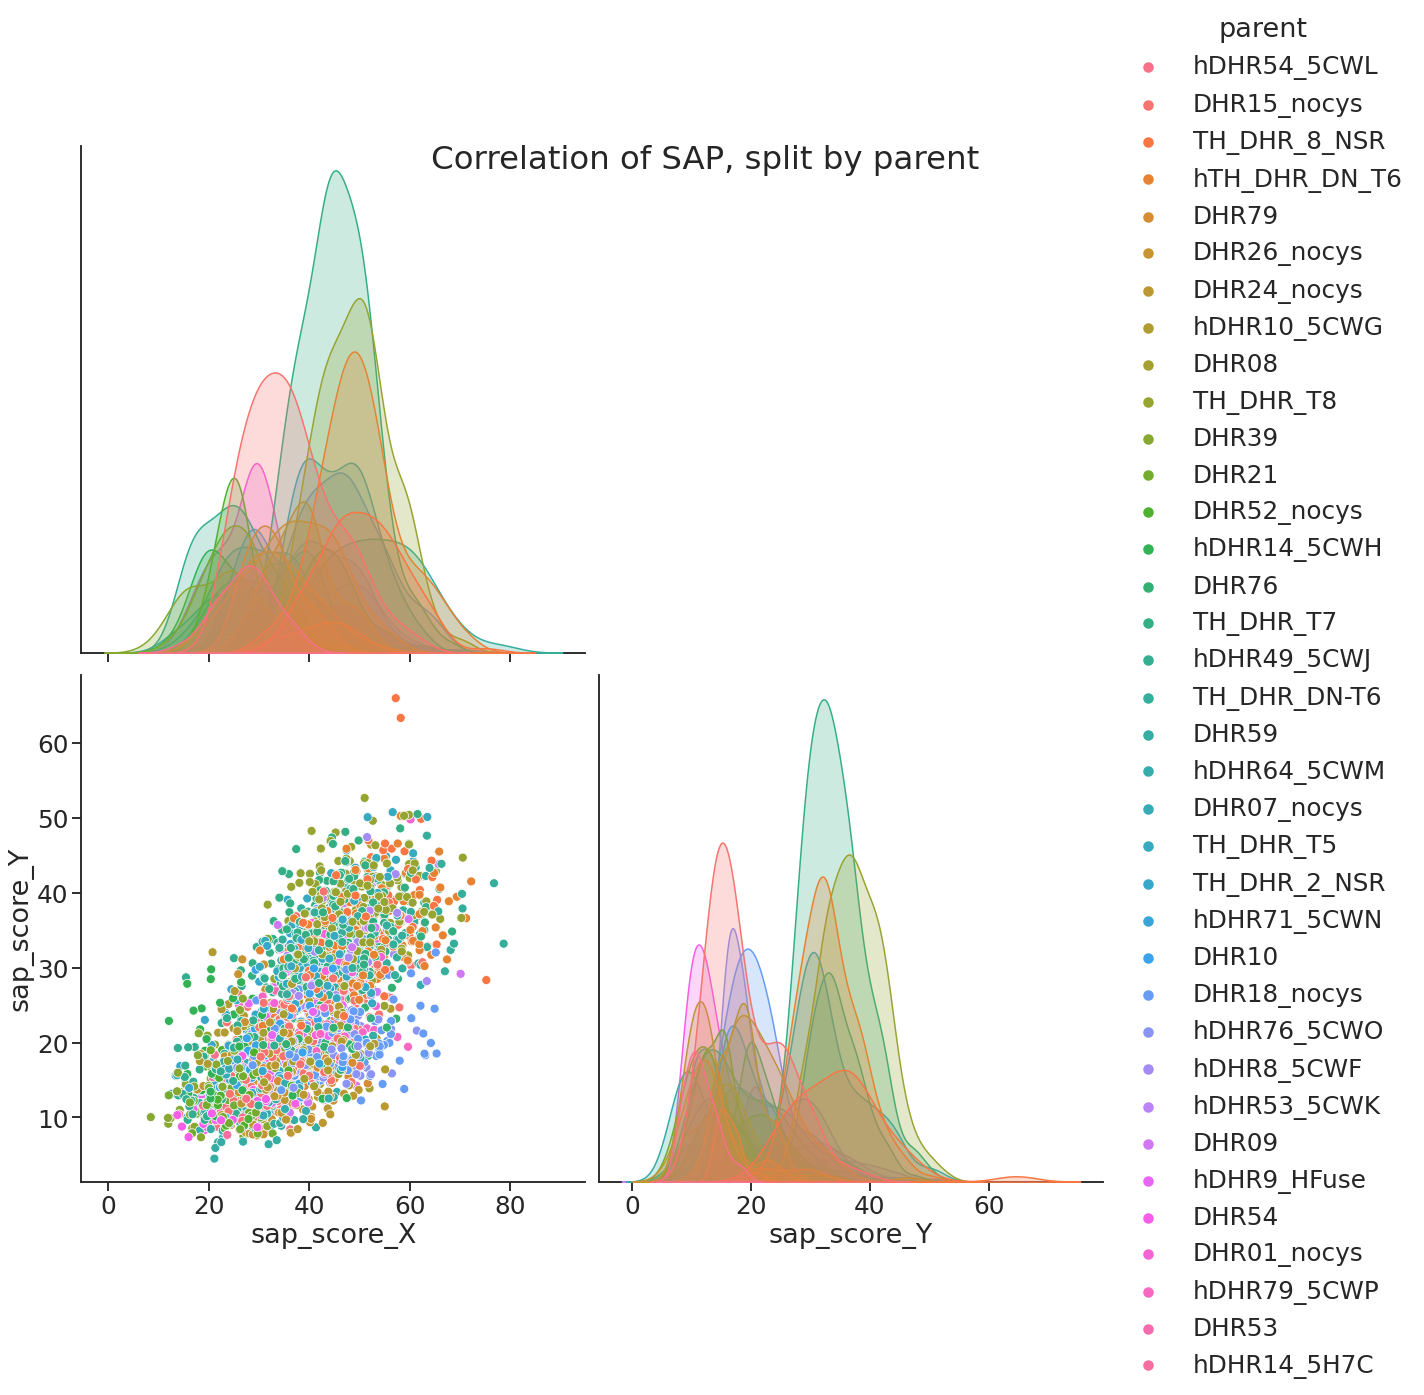

In [6]:
sap_subset = scores_df[
    [
        "sap_score_X",
        "sap_score_Y",
        "parent",
    ]
]

ax = sns.pairplot(
    data=sap_subset.sample(frac=0.01), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of SAP, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_sap_split_by_parent.png")

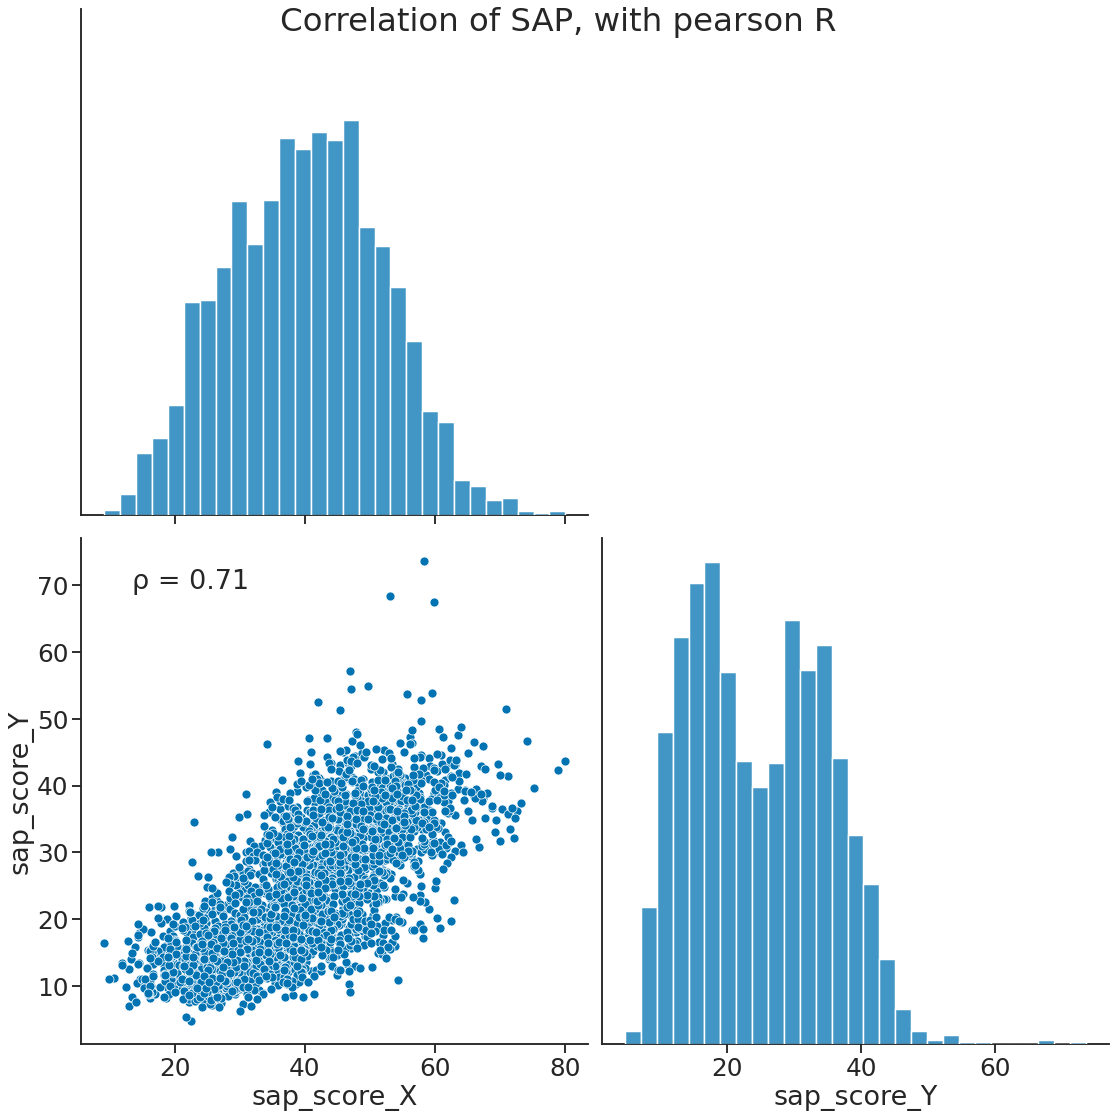

In [7]:
def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy

    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(0.1, 0.9), xycoords=ax.transAxes)


ax = sns.pairplot(data=sap_subset.sample(frac=0.01), corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of SAP, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_SAP_pearson.png")

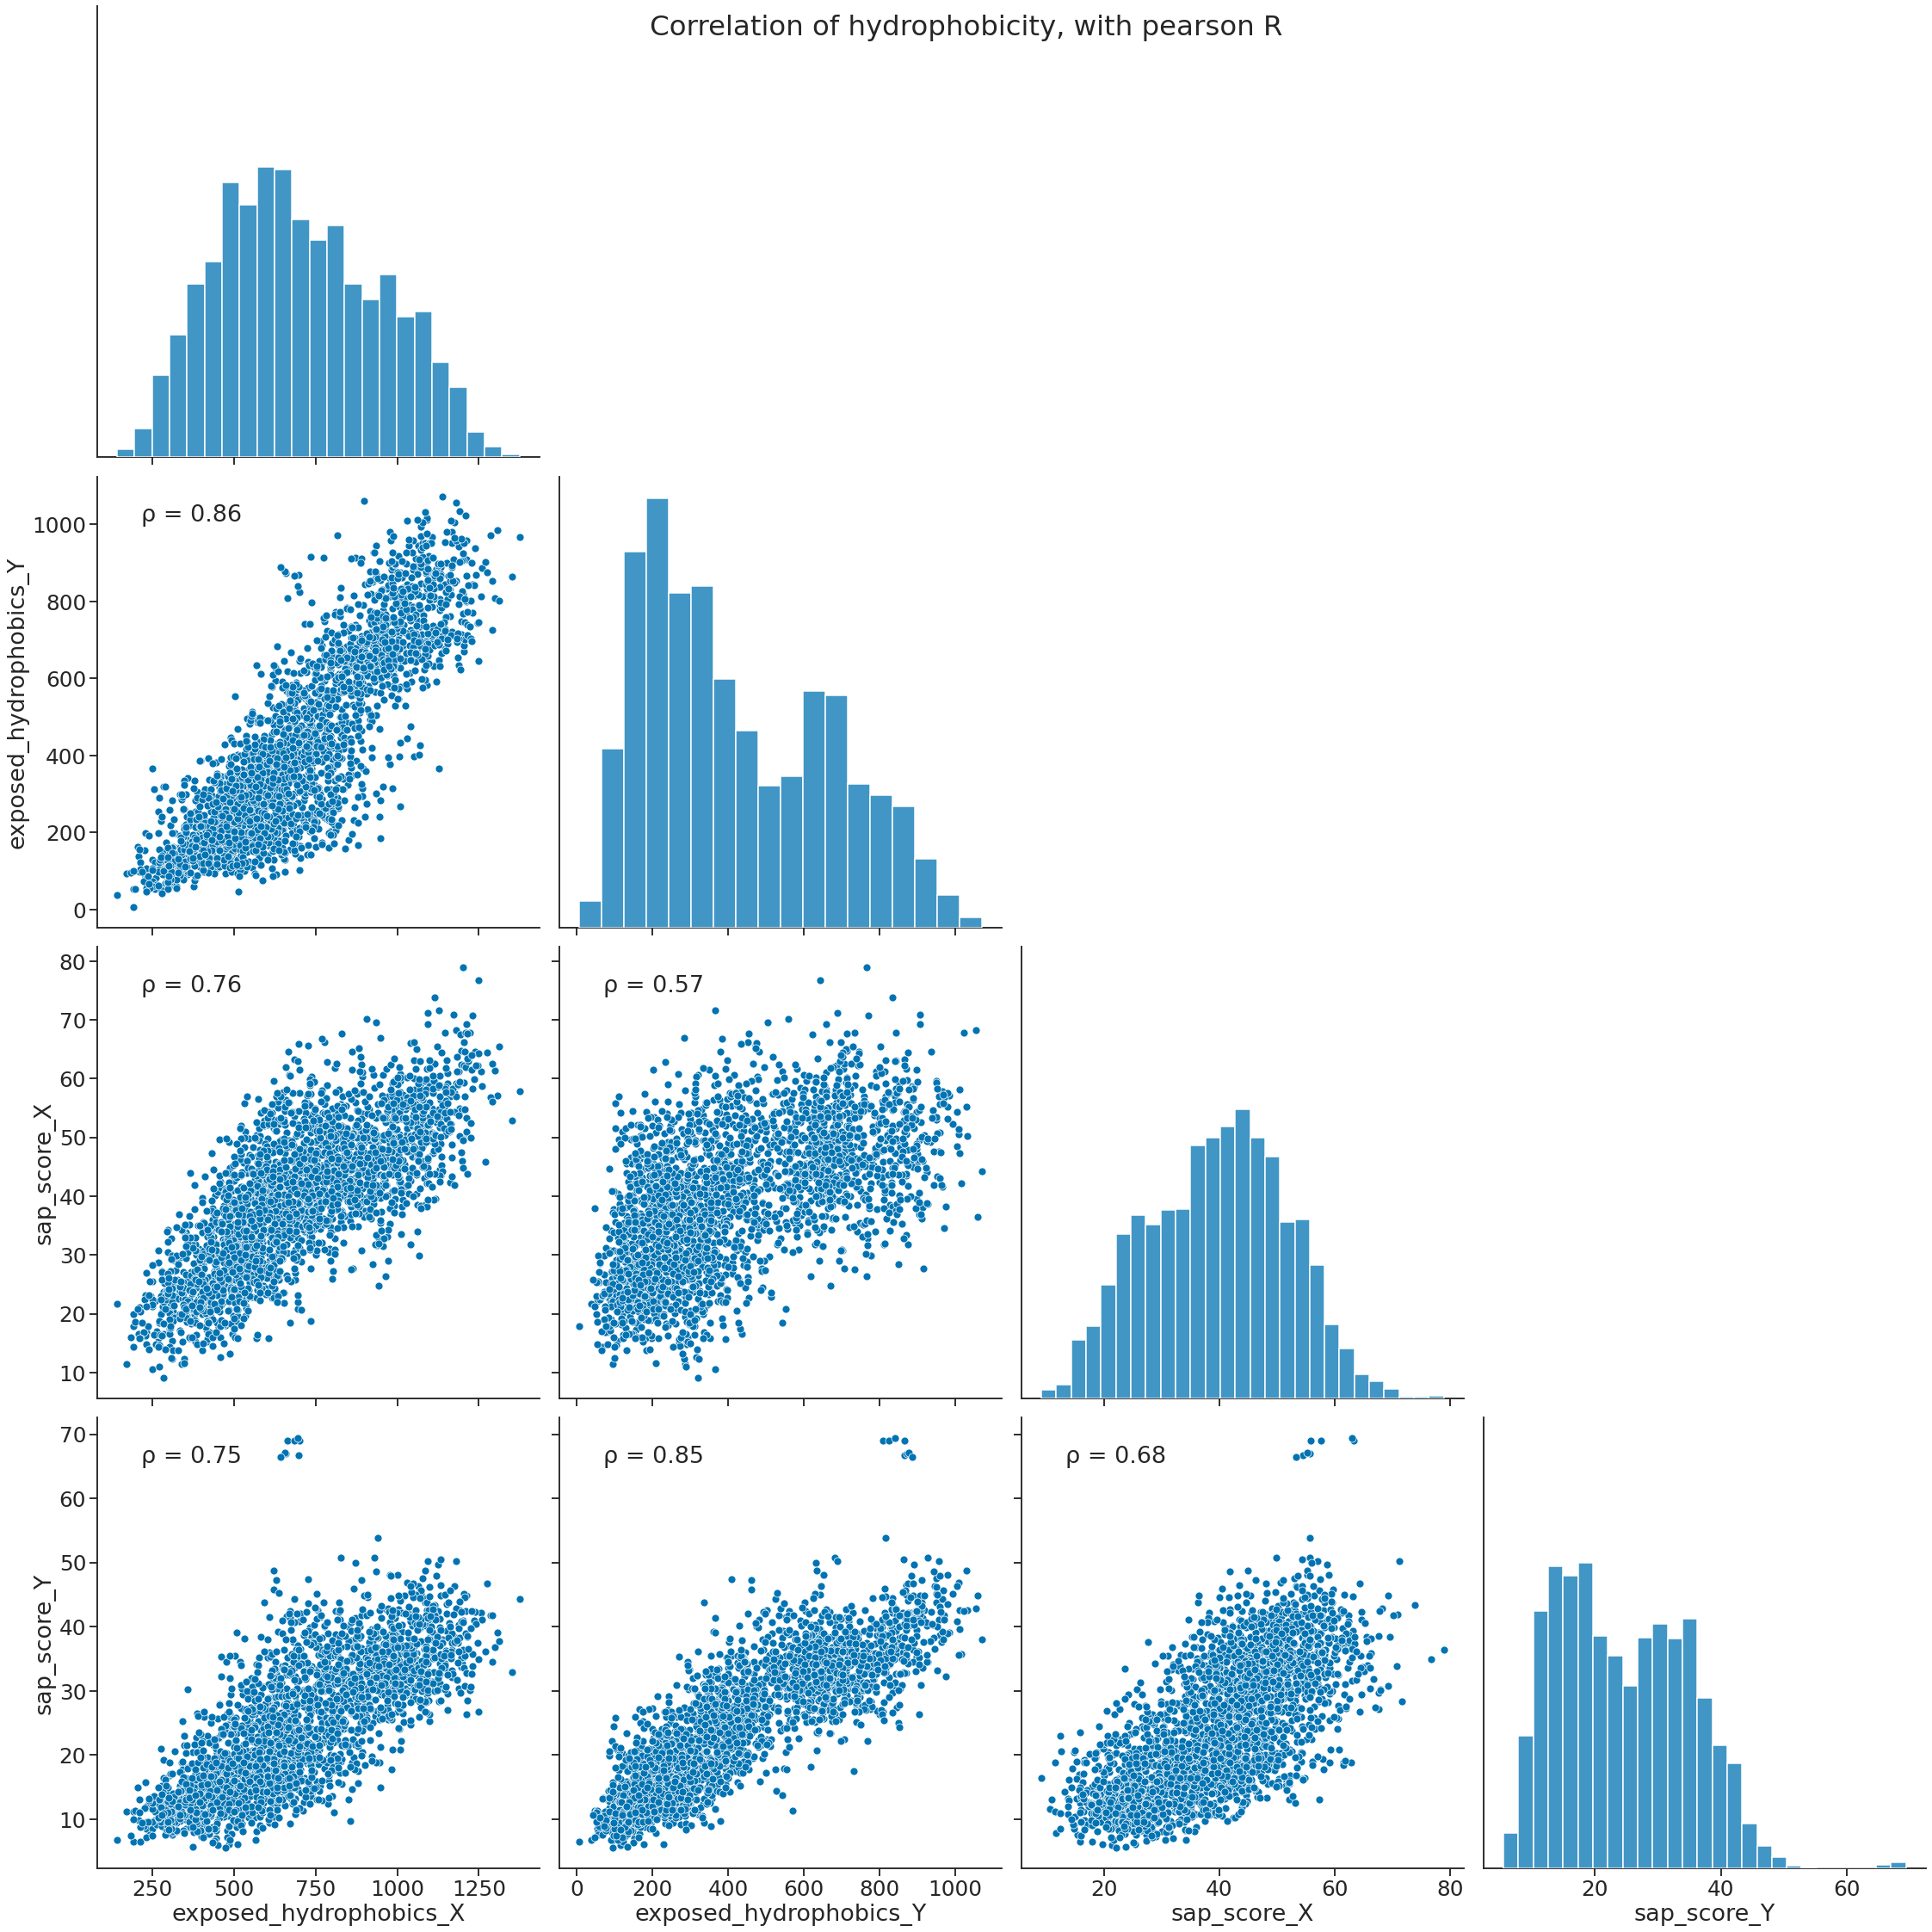

In [8]:
sap_subset = scores_df[
    [
        "exposed_hydrophobics_X",
        "exposed_hydrophobics_Y",
        "sap_score_X",
        "sap_score_Y",
        "parent",
    ]
]

ax = sns.pairplot(
    data=sap_subset.sample(frac=0.01), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of hydrophobicity, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_hydrophobicity_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=sap_subset.sample(frac=0.01), corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of hydrophobicity, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_hydrophobicity_pearson.png")

### Fragment quality

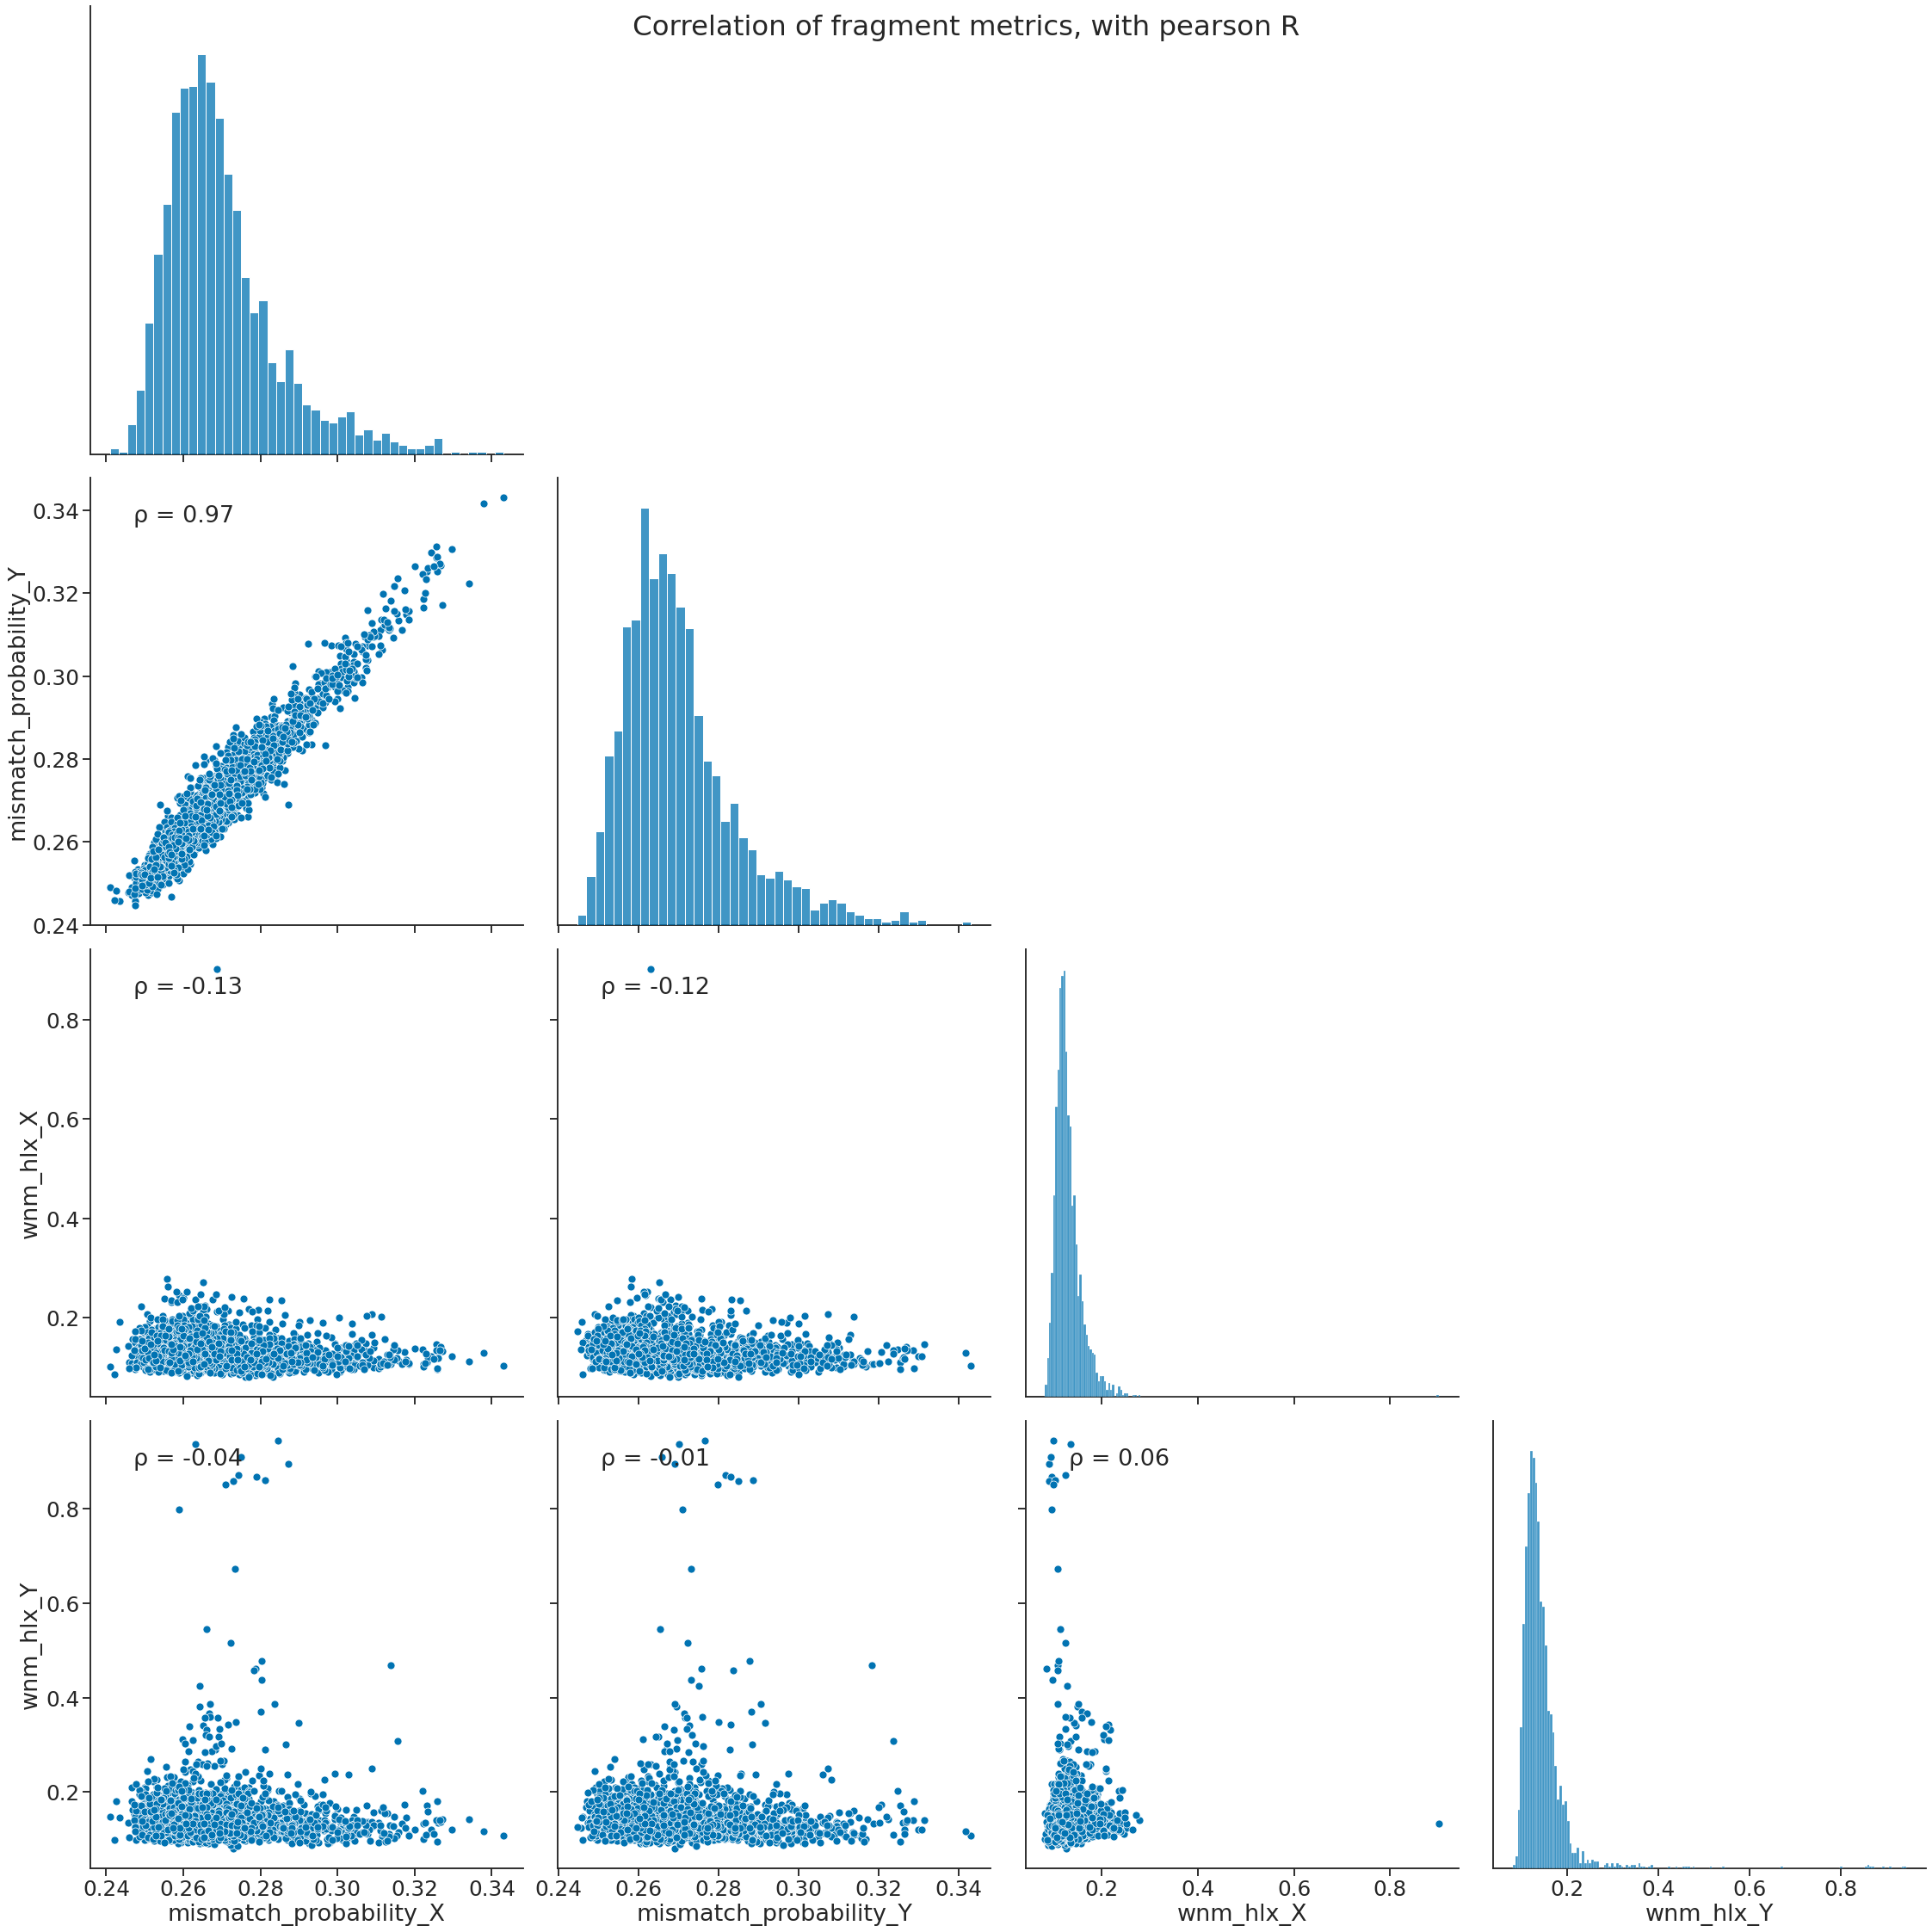

In [9]:
frag_subset = scores_df[
    [
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "parent",
    ]
]

ax = sns.pairplot(
    data=frag_subset.sample(frac=0.01), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of fragment metrics, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_frag_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=frag_subset.sample(frac=0.01), corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of fragment metrics, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_frag_pearson.png")

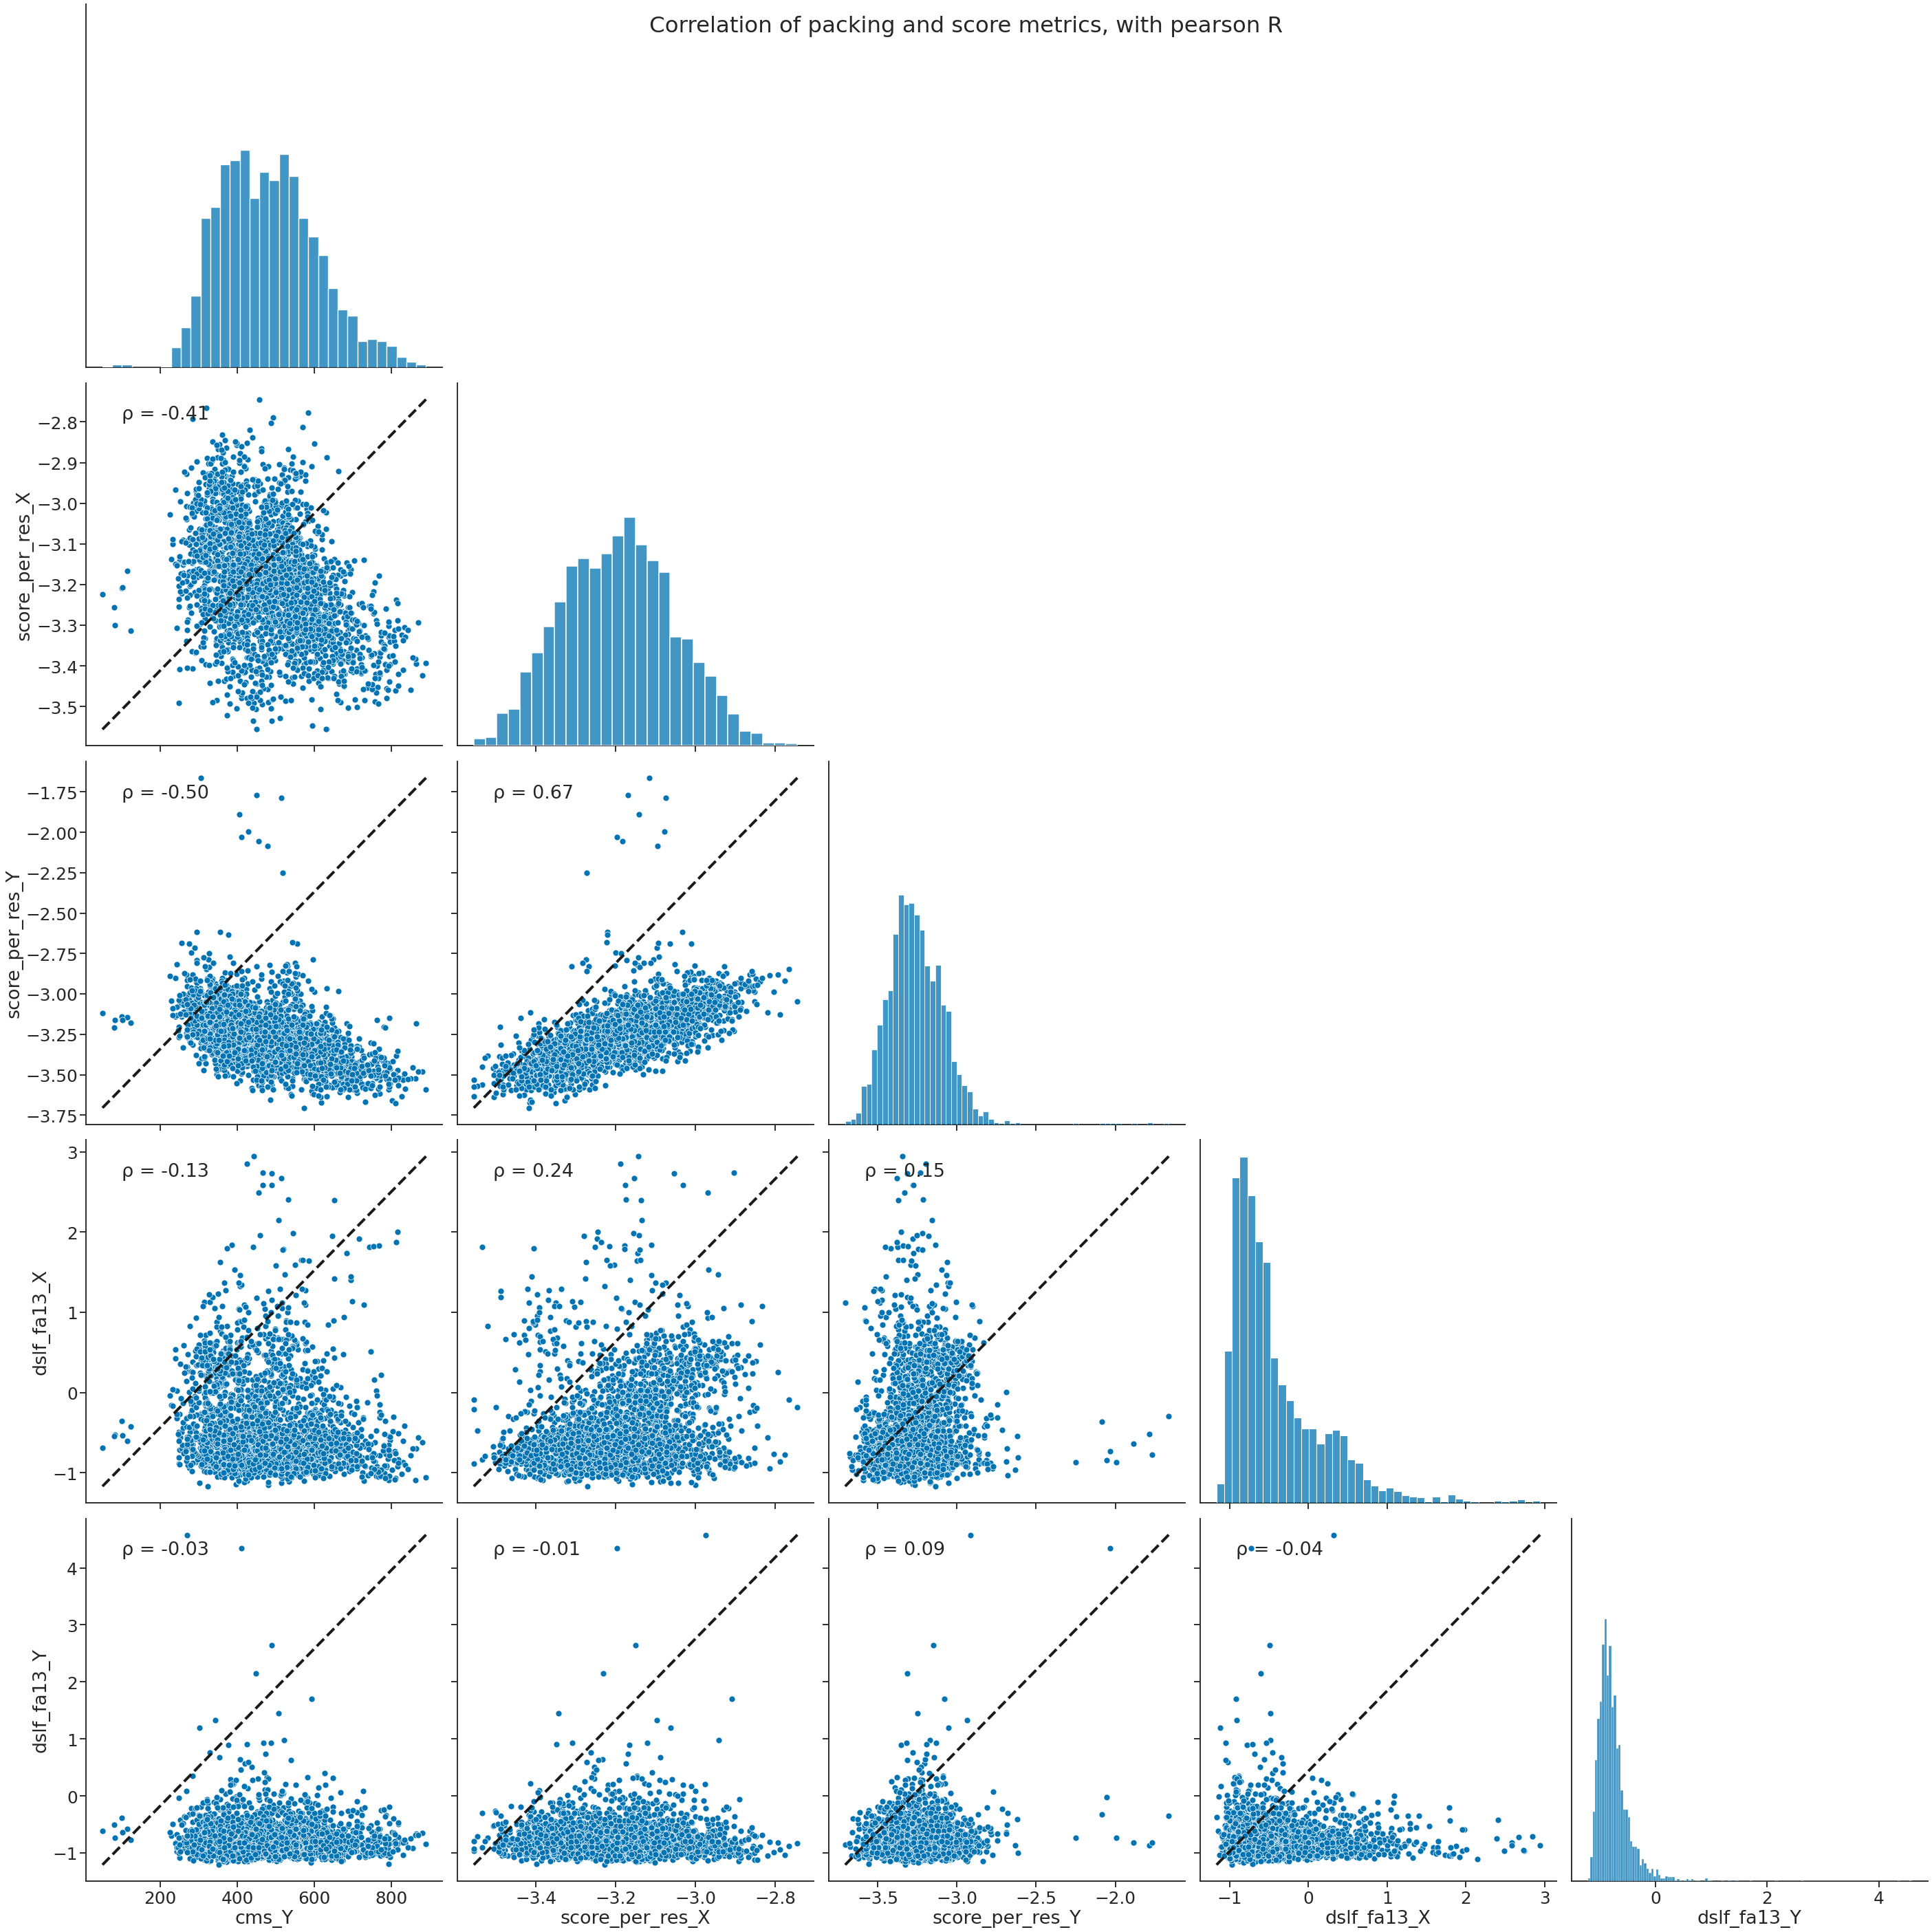

In [10]:
def plot_unity(xdata, ydata, **kwargs):
    """https://stackoverflow.com/questions/48122019/how-can-i-plot-identity-lines-on-a-seaborn-pairplot"""
    xmin, ymin = (xdata.min(), ydata.min())
    xmax, ymax = (xdata.max(), ydata.max())
    xpoints = np.linspace(xmin, xmax, 100)
    ypoints = np.linspace(ymin, ymax, 100)
    plt.gca().plot(
        xpoints, ypoints, color="k", marker=None, linestyle="--", linewidth=4.0
    )


pack_subset = scores_df[
    [
        "cms_Y",
        "score_per_res_X",
        "score_per_res_Y",
        "dslf_fa13_X",
        "dslf_fa13_Y",
        "parent",
    ]
]

ax = sns.pairplot(
    data=pack_subset.sample(frac=0.01), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of packing and score metrics, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_pack_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=pack_subset.sample(frac=0.01), corner=True, height=8)
ax.map_lower(rho)
ax.map_offdiag(plot_unity)
plt.suptitle("Correlation of packing and score metrics, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_pack_pearson.png")

### Did the penalties affect packing metrics?

/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


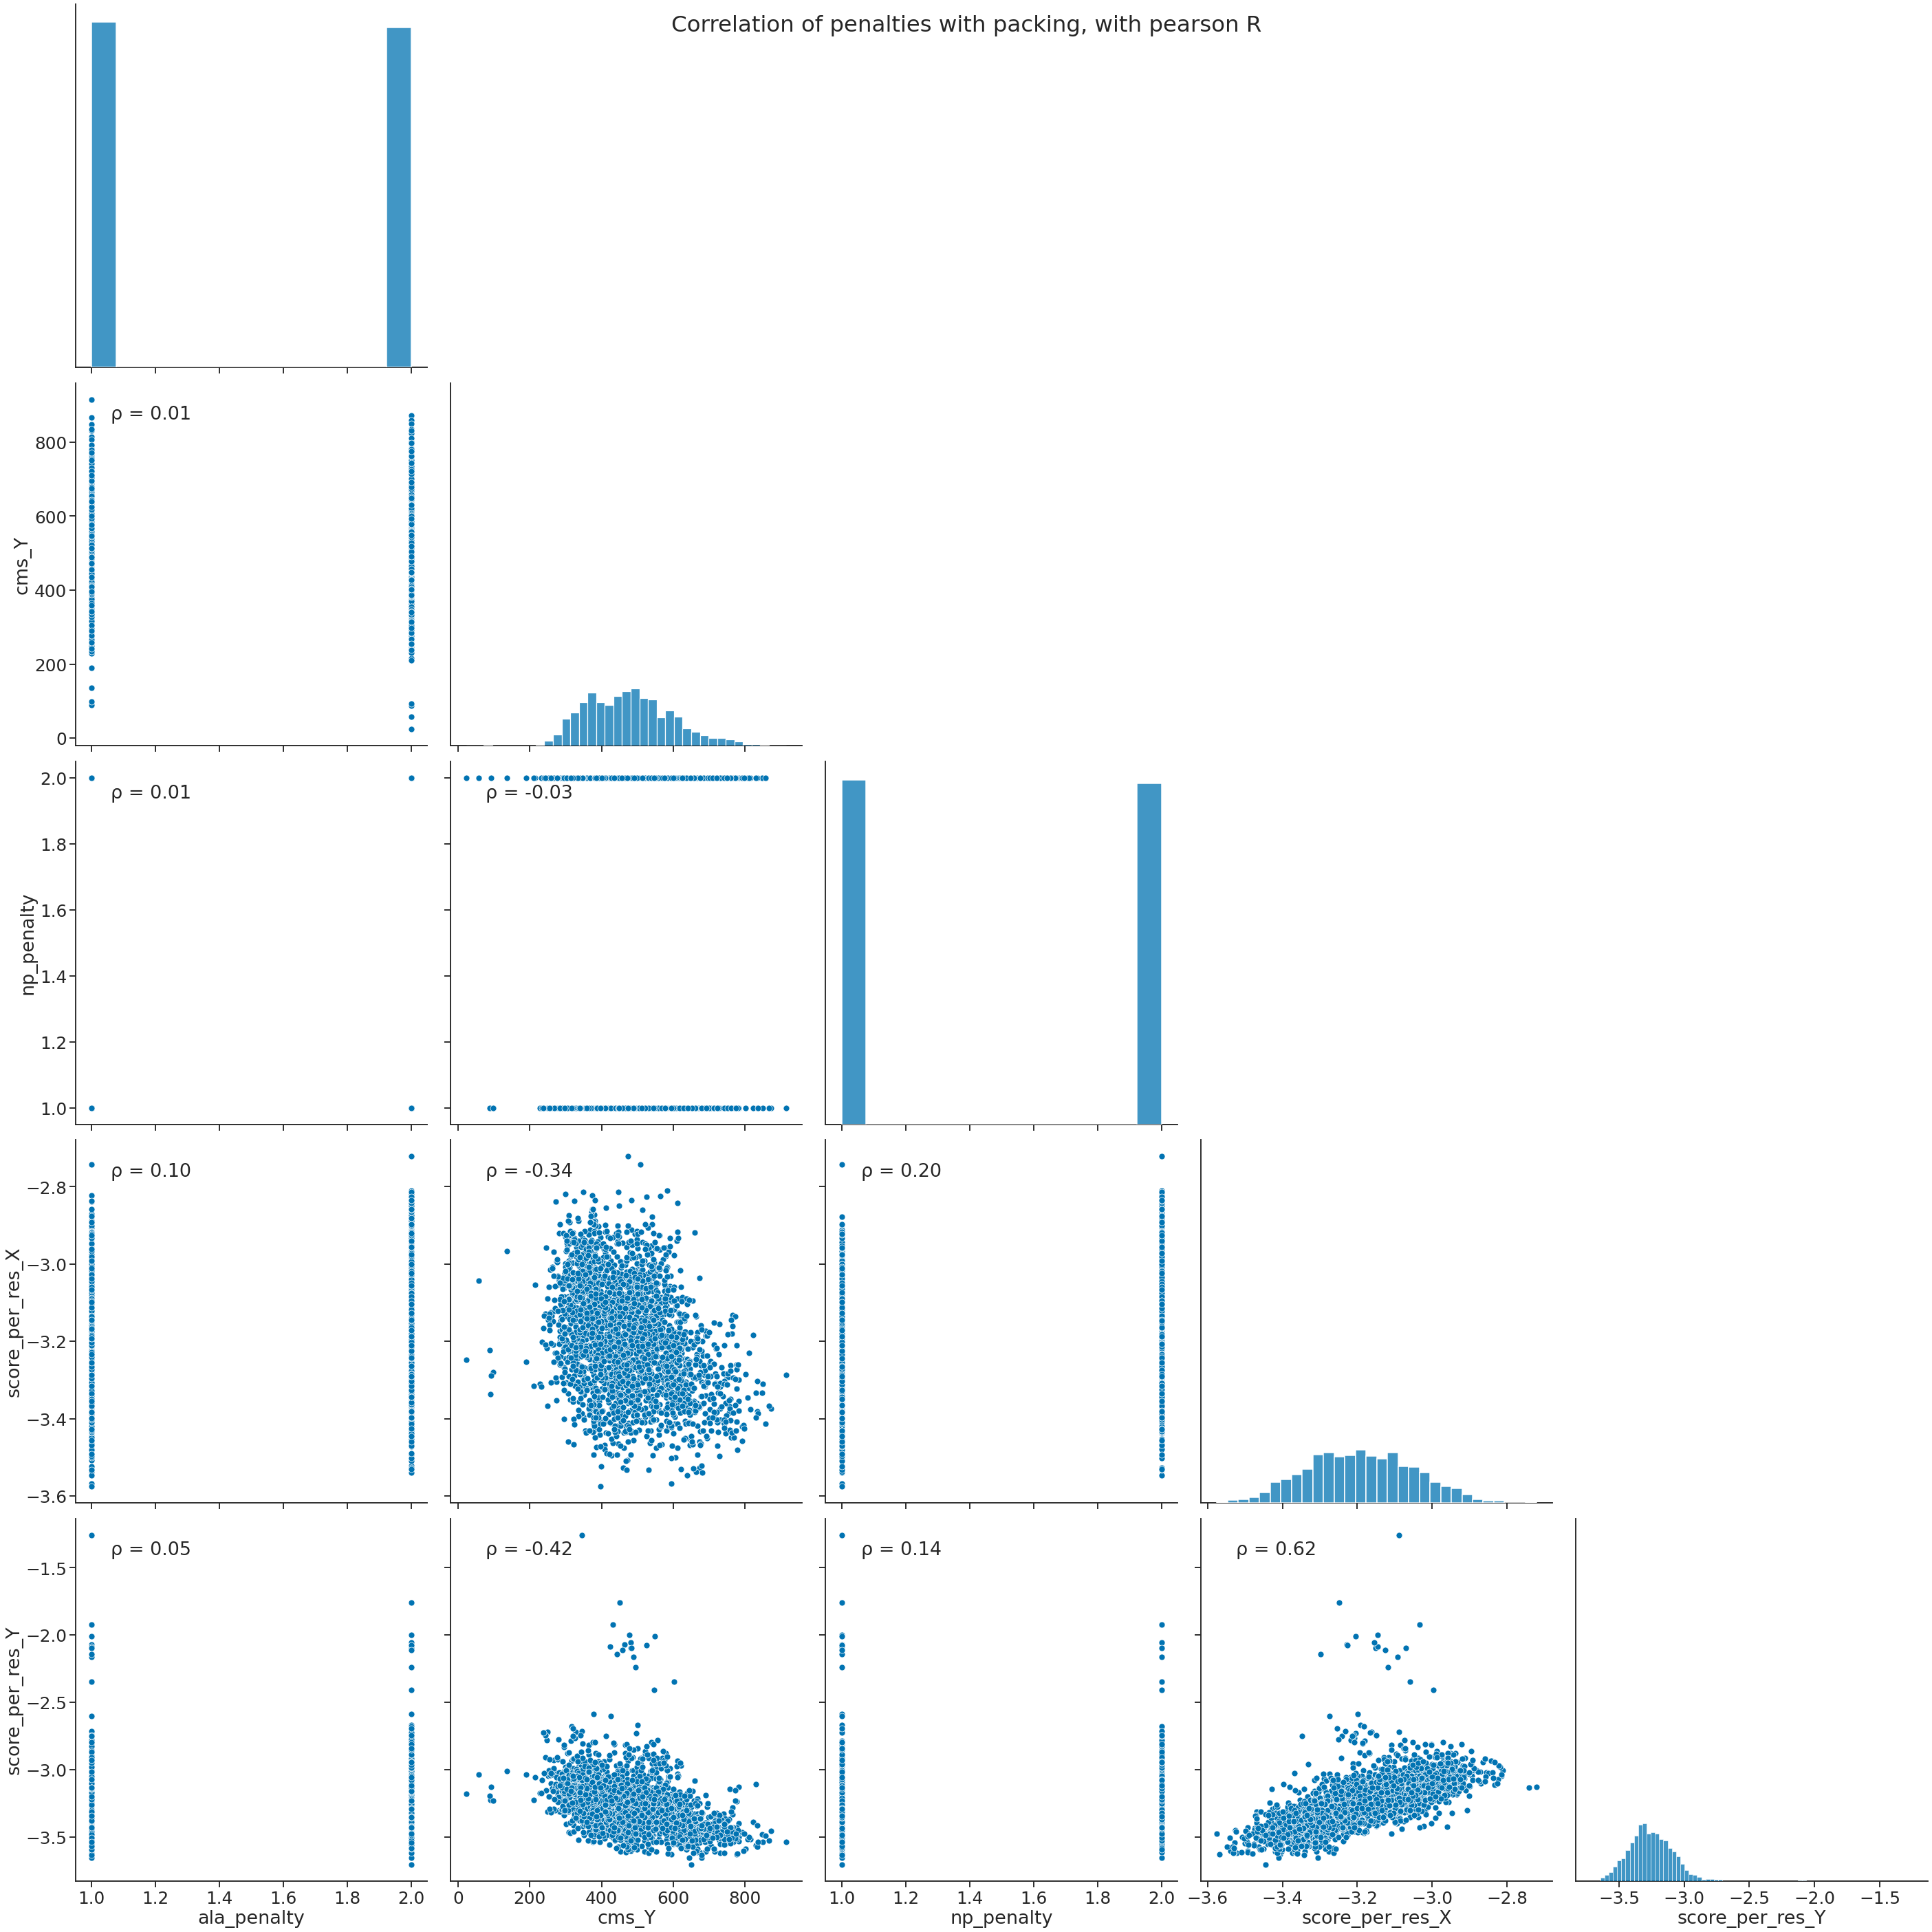

In [11]:
penalty_subset = scores_df[
    [
        "ala_penalty",
        "cms_Y",
        "np_penalty",
        "score_per_res_X",
        "score_per_res_Y",
        "parent",
    ]
]

ax = sns.pairplot(
    data=penalty_subset.sample(frac=0.01), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of penalties with packing, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_penalties_packing_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=penalty_subset.sample(frac=0.01), corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of penalties with packing, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_penalties_packing_pearson.png")

### Did the penalties affect solubility metrics?

/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


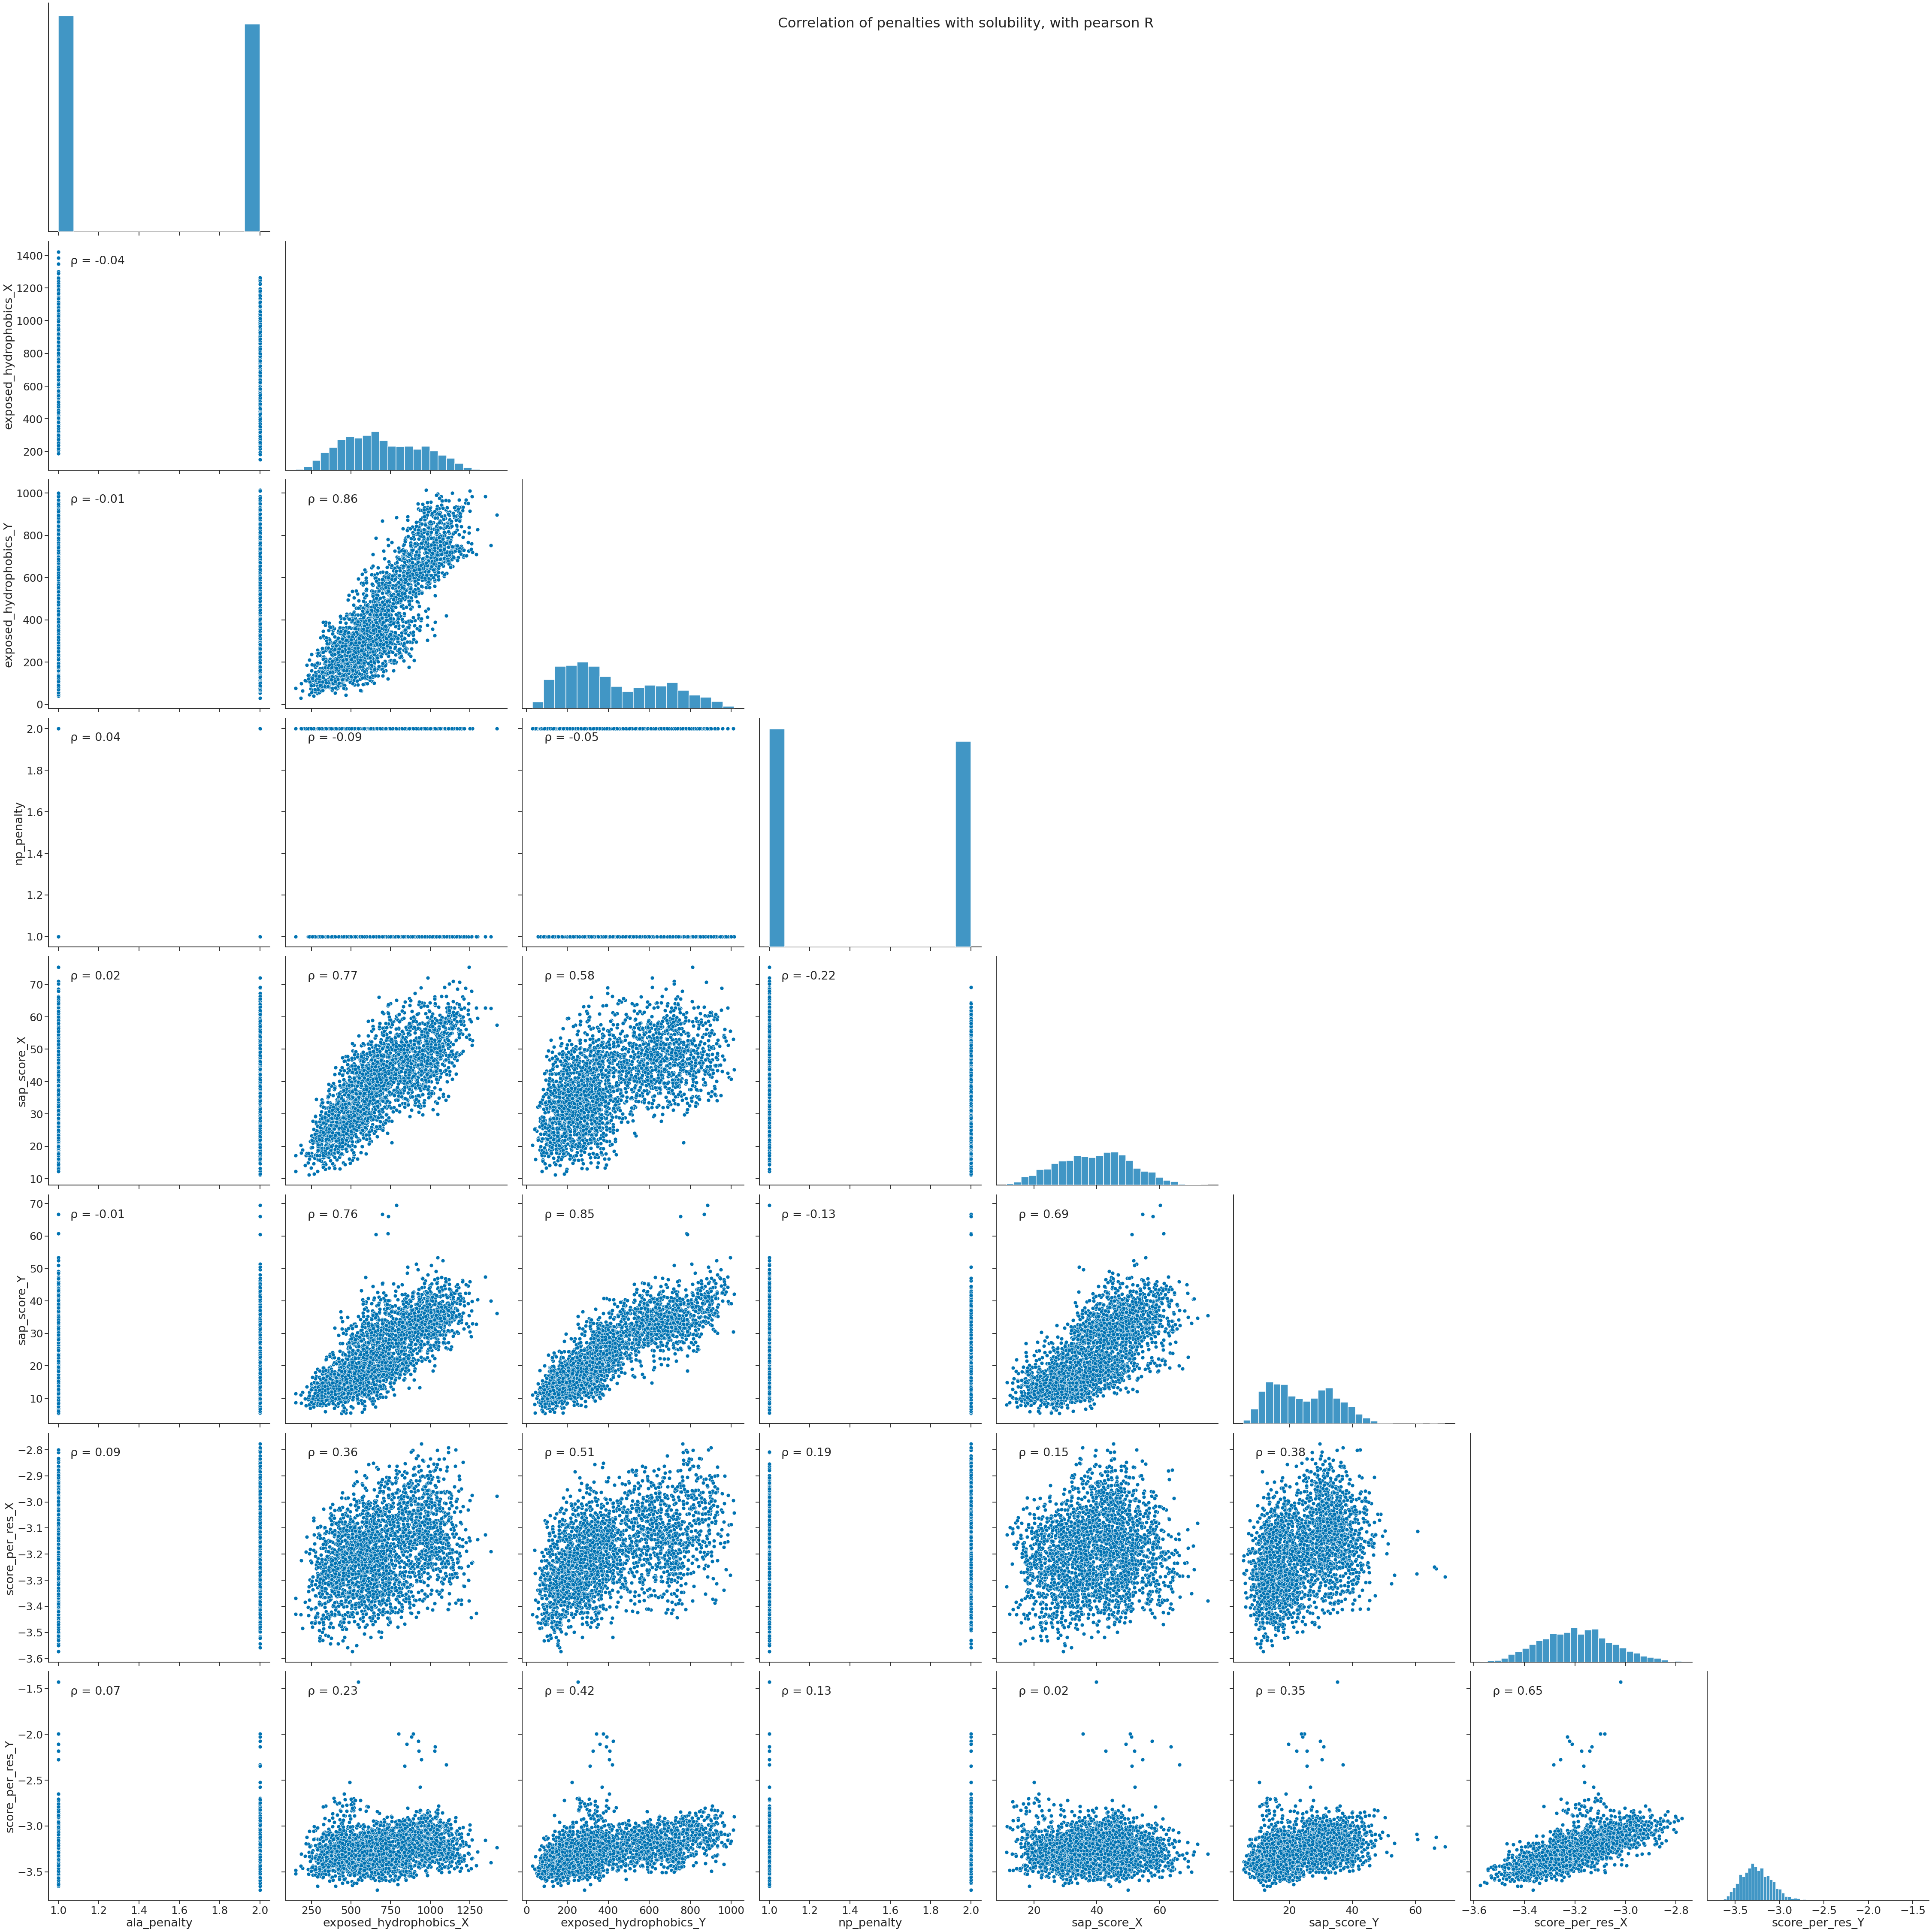

In [12]:
penalty_subset = scores_df[
    [
        "ala_penalty",
        "exposed_hydrophobics_X",
        "exposed_hydrophobics_Y",
        "np_penalty",
        "sap_score_X",
        "sap_score_Y",
        "score_per_res_X",
        "score_per_res_Y",
        "parent",
    ]
]

ax = sns.pairplot(
    data=penalty_subset.sample(frac=0.01), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of penalties with solubility, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_penalties_solubility_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=penalty_subset.sample(frac=0.01), corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of penalties with solubility, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_penalties_solubility_pearson.png")

### Pairwise analysis of certain scoreterms

### Get the decent decoys for each state after removing really bad stuff
`sap_score < 27`  
`score_per_res < -3`  
`vbuns < 2`  
`wnm_all < 0.8`  
`wnm_hlx < 0.15`  
Won't filter on TRP or AAA just yet, if I did it would be:  
`"AAA" < 3`  
`"W" == 1`

In [25]:
def row2state(row):
    state = (
        row["parent"]
        + "_p_"
        + str(int(row["pivot_helix"]))
        + "_s_"
        + str(int(row["shift"]))
    )
    return state


decent = scores_df[scores_df["sap_score_X"] < 27]
decent = decent[decent["sap_score_Y"] < 27]
decent = decent[decent["score_per_res_X"] < -3]
decent = decent[decent["score_per_res_Y"] < -3]
decent = decent[decent["vbuns_X"] < 2]
decent = decent[decent["vbuns_Y"] < 2]
decent = decent[decent["wnm_hlx_X"] < 0.15]
decent = decent[decent["wnm_hlx_Y"] < 0.15]


decent["state"] = decent.apply(row2state, axis=1)

print(len(set(decent.state.values)))
print(len(decent))
print(len(set(decent.parent.values)))
set(scores_df.parent.values) - set(decent.parent.values)

85
23463
28


{'DHR01_nocys',
 'DHR53',
 'DHR79',
 'TH_DHR_8_NSR',
 'TH_DHR_T5',
 'TH_DHR_T7',
 'TH_DHR_T8',
 'hDHR53_5CWK'}

In [14]:
with open(os.path.join(os.getcwd(), "05_filter", "decent_sap27_vbuns1.list"), "w") as f:
    for i in decent.index:
        print(i, file=f)

### Now get the best interfaces

In [19]:
list(decent.columns)

['abego_str_Y',
 'bb_clash',
 'bb_clash_Y',
 'closure_type_X',
 'closure_type_Y',
 'cmsa_AB_Y',
 'cmsa_AC_Y',
 'cmsa_BC_Y',
 'disulfide_at_X',
 'disulfide_at_Y',
 'docked_helix_Y',
 'dssp_Y',
 'interface_buried_sasa_Y',
 'new_loop_resis',
 'new_loop_resis_X',
 'new_loop_resis_Y',
 'parent',
 'parent_X',
 'parent_Y',
 'parent_length_Y',
 'parent_sequence',
 'pivot_helix',
 'pivot_helix_Y',
 'pre_break_helix',
 'pre_break_helix_Y',
 'sasa_AB_Y',
 'sasa_AC_Y',
 'sasa_BC_Y',
 'sc_int_AB_Y',
 'sc_int_AC_Y',
 'sc_int_BC_Y',
 'score_AB_Y',
 'score_AC_Y',
 'score_BC_Y',
 'shift',
 'shift_Y',
 '9mer_X',
 '9mer_Y',
 'ala_penalty',
 'buns_X',
 'buns_Y',
 'cms_Bc_Y',
 'cms_Y',
 'cms_nB_Y',
 'cms_nc_Y',
 'cmsa_int_Y',
 'ddg_Y',
 'dslf_fa13_X',
 'dslf_fa13_Y',
 'dslf_fa13_cart_X',
 'dslf_fa13_cart_Y',
 'dslf_fa13_swap_Y',
 'exposed_hydrophobics_X',
 'exposed_hydrophobics_Y',
 'fa_atr_X',
 'fa_atr_Y',
 'fa_dun_dev_X',
 'fa_dun_dev_Y',
 'fa_dun_rot_X',
 'fa_dun_rot_Y',
 'fa_dun_semi_X',
 'fa_dun_semi_

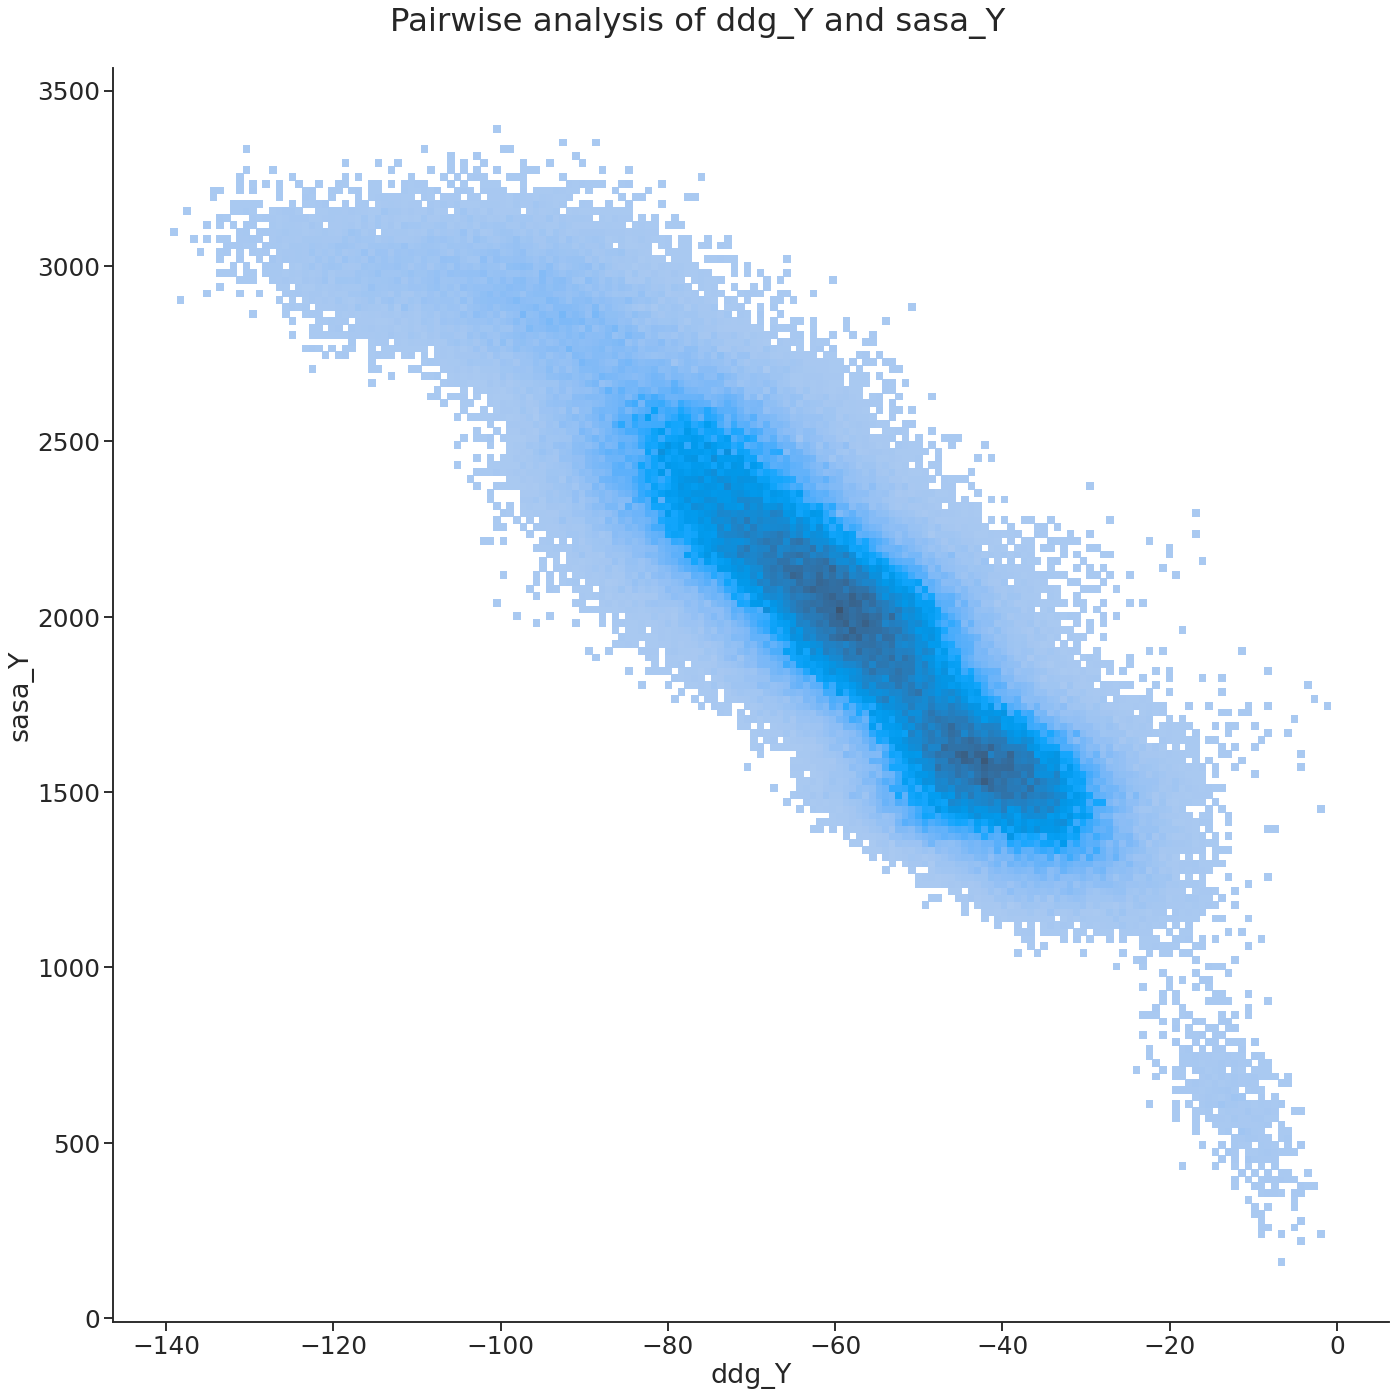

In [15]:
scores_df = scores_df[scores_df["ddg_Y"] < 0]  # we don't want any crazy numbers

fig, ax = plt.subplots(figsize=(20, 20), tight_layout=True)
sns.histplot(ax=ax, data=scores_df, x="ddg_Y", y="sasa_Y", palette="colorblind")
plt.suptitle(f"Pairwise analysis of ddg_Y and sasa_Y")
sns.despine()
plt.savefig(f"figs/05_pairwise_ddg_sasa_Y.png")

In [26]:
good = decent[decent["sap_score_Y"] < 25]
good = good[good["vbuns_X"] < 1]
good = good[good["vbuns_Y"] < 1]
good = good[good["ddg_Y"] < -40]
good = good[good["sasa_Y"] > 1350]

print(len(set(good.state.values)))
print(len(good))
set(scores_df.parent.values) - set(good.parent.values)

77
10143


{'DHR01_nocys',
 'DHR18_nocys',
 'DHR53',
 'DHR76',
 'DHR79',
 'TH_DHR_8_NSR',
 'TH_DHR_DN-T6',
 'TH_DHR_T5',
 'TH_DHR_T7',
 'TH_DHR_T8',
 'hDHR53_5CWK'}

In [27]:
with open(os.path.join(os.getcwd(), "05_filter", "good.list"), "w") as f:
    for i in good.index:
        print(i, file=f)

In [ ]:
!mv *.sh *.cmds 05_msd_test

### Unused blocks

In [ ]:
good["d_tot_score"] = good["total_score_X"] - good["total_score_Y"]
plt.hist(good["d_tot_score"])
plt.title("distribution of total score delta")
test = good.query("d_tot_score < -40 | d_tot_score > 40")

print(len(set(test.state.values)))
print(len(test))
set(scores_df.parent.values) - set(test.parent.values)

### Get reference values for state X
for filtering purposes

In [ ]:
from pyrosetta.distributed import requires_init
from pyrosetta.distributed.packed_pose.core import PackedPose


@requires_init
def score_ref(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Score the parents for purposes of comparison
    """
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    if packed_pose_in == None:
        packed_pose_in = io.pose_from_file(kwargs["-s"])
    else:
        raise RuntimeError
    parent = kwargs["-s"].split("/")[-1].replace(".pdb", "")
    pre_break_helix = kwargs["pre_break_helix"]
    sfxn = "beta_nov16"
    xml = """
        <ROSETTASCRIPTS>
            <SCOREFXNS>
                <ScoreFunction name="sfxn" weights="{sfxn}" />
                <ScoreFunction name="sfxn_design" weights="{sfxn}" >
                    <Set use_hb_env_dep="true" />
                    <Reweight scoretype="approximate_buried_unsat_penalty" weight="17" />
                    <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                    <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-1.0" />
                    <Set approximate_buried_unsat_penalty_natural_corrections1="true" />
                    <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-7" />
                    <Set approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb="1"/>                    
                </ScoreFunction>
            </SCOREFXNS>
            <RESIDUE_SELECTORS>
                <SSElement name="part1" selection="n_term" to_selection="{pre},H,E" chain="A" reassign_short_terminal_loop="2" />
                <SSElement name="part2" selection="-{post},H,S" to_selection="c_term" chain="A" reassign_short_terminal_loop="2" />
            </RESIDUE_SELECTORS>
            <TASKOPERATIONS>
                <IncludeCurrent name="current" />
                <LimitAromaChi2 name="arochi" chi2max="110" chi2min="70" include_trp="True" />
                <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" />
                <InitializeFromCommandline name="ifcl"/>
            </TASKOPERATIONS>
            <MOVERS>
                <SavePoseMover name="save_before_relax" restore_pose="0" reference_name="before_relax"/>
            </MOVERS>
            <FILTERS>
                <BuriedUnsatHbonds name="vbuns" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" 
                    scorefxn="sfxn" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" 
                    use_ddG_style="false" dalphaball_sasa="true" probe_radius="1.1" atomic_depth_selection="5.5" 
                    burial_cutoff="1000" burial_cutoff_apo="0.2" />
                <BuriedUnsatHbonds name="sbuns" use_reporter_behavior="true" report_all_heavy_atom_unsats="true"
                    scorefxn="sfxn" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0"
                    use_ddG_style="false" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1" 
                    atomic_depth_selection="5.5" atomic_depth_deeper_than="false" />
                <BuriedUnsatHbonds name="buns" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" 
                    scorefxn="sfxn" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" 
                    use_ddG_style="false" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1"
                    max_hbond_energy="1.5" burial_cutoff_apo="0.2" />
                <ContactMolecularSurface name="cms" verbose="true" target_selector="part1" binder_selector="part2"/>
                <ExposedHydrophobics name="exposed_hydrophobics" />
                <Geometry name="geometry"
                    confidence="0"
                    count_bad_residues="true" />
                <SSPrediction name="mismatch_probability" confidence="0" 
                    cmd="/software/psipred4/runpsipred_single" use_probability="1" 
                    mismatch_probability="1" use_svm="1" />
                <Rmsd name="rmsd_final" reference_name="before_relax" chains="A" superimpose="1" threshold="5" by_aln="0" confidence="0" />
                <ScoreType name="total_score_pose" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
                <ResidueCount name="count" />
                <CalculatorFilter name="score_per_res" equation="total_score_full / res" threshold="-2.0" confidence="0">
                    <Var name="total_score_full" filter="total_score_pose"/>
                    <Var name="res" filter="count"/>
                </CalculatorFilter>        
                <worst9mer name="wnm_all" rmsd_lookup_threshold="0.4" confidence="0" />
                <worst9mer name="wnm_hlx" rmsd_lookup_threshold="0.4" confidence="0" only_helices="true" />

            </FILTERS>
            <MOVERS>
                <FastRelax name="relax" scorefxn="sfxn_design" repeats="1" batch="false" ramp_down_constraints="false"
                    cartesian="false" bondangle="false" bondlength="false" min_type="dfpmin_armijo_nonmonotone"
                    task_operations="ifcl,current,arochi,ex1_ex2" >
                </FastRelax>
            </MOVERS>
            <SIMPLE_METRICS>
                <SapScoreMetric name="sap_score" />
            </SIMPLE_METRICS>
            <APPLY_TO_POSE>
            </APPLY_TO_POSE>
            <PROTOCOLS>
                <Add mover_name="save_before_relax" />
                <Add mover_name="relax"/>
                <Add filter_name="buns" />
                <Add filter_name="sbuns" />
                <Add filter_name="vbuns" />
                <Add filter_name="cms" />
                <Add filter_name="exposed_hydrophobics" />
                <Add filter_name="geometry"/>
                <Add filter_name="mismatch_probability" />
                <Add filter_name="rmsd_final" />
                <Add metrics="sap_score" />
                <Add filter_name="score_per_res" />
                <Add filter_name="wnm_all" />
                <Add filter_name="wnm_hlx" />
            </PROTOCOLS>
            <OUTPUT scorefxn="sfxn" />
        </ROSETTASCRIPTS>
    """.format(
        sfxn=sfxn,
        pre=pre_break_helix,
        post=pre_break_helix,
    )
    scored = SingleoutputRosettaScriptsTask(xml)
    scored_ppose = scored(packed_pose_in.pose.clone())
    pose = io.to_pose(scored_ppose)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "parent", parent)
    scored_ppose = io.to_packed(pose)
    return scored_ppose

### Setup dask, set command line options, make tasks and submit to client for scoring ref
Run `nstruct` of 5 to cover bases for stochasticity

In [ ]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)


def create_tasks(selected, options):
    for file in selected:
        tasks = {"options": "-corrections::beta_nov16 true"}
        tasks["extra_options"] = options
        tasks["-s"] = file
        if "THR" in file:
            tasks["pre_break_helix"] = 6
        else:
            tasks["pre_break_helix"] = 4
        yield tasks


logging.basicConfig(level=logging.INFO)
pdbs = glob(os.path.join(os.getcwd(), "00_inputs/*/*.pdb"))

options = {
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
}

output_path = os.path.join(os.getcwd(), "05_score_ref")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="long",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=510,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(pdbs, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
                nstruct=5,
            ).distribute(protocols=[score_ref])

### Look at scores
Hacky function to load JSON-like data

In [3]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "05_score_ref")
scores = os.path.join(output_path, "scores.json")

### Get reference scores

In [ ]:
ref_df = read_scorefile(scores)
ref_df